# 載入所需套件

In [1]:
import numpy as np
import pandas as pd  
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import backtrader as bt
import backtrader.feeds as btfeeds
from datetime import datetime,timedelta

style.use('seaborn')
# 設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus']=False
register_matplotlib_converters()

%matplotlib inline   

# 匯入外部台指期1分K資料

In [2]:
df=pd.read_csv('TXF最新資料.txt')
df.columns=['date','time','open','high','low','close','volume']
df['datetime']=(df['date']+' '+df['time']).apply(lambda x:datetime.strptime(x,'%Y/%m/%d %H:%M:%S'))
df=df[['datetime','open','high','low','close','volume']]
df.set_index(['datetime'],inplace=True)
df.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:46:00,8203,8208,8184,8189,1125
2010-01-04 08:47:00,8188,8195,8186,8193,411
2010-01-04 08:48:00,8194,8201,8193,8201,422
2010-01-04 08:49:00,8201,8203,8198,8201,297
2010-01-04 08:50:00,8199,8200,8195,8197,189


# 更改資料頻率為15分K資料

In [3]:
method={'open':'first',
        'high':'max',
        'low':'min',
        'close':'last',
        'volume':'sum'}

df_15min=df.resample('15min').apply(method).dropna()
df_15min.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:45:00,8203.0,8208.0,8184.0,8194.0,3886
2010-01-04 09:00:00,8194.0,8206.0,8181.0,8197.0,5975
2010-01-04 09:15:00,8197.0,8211.0,8195.0,8207.0,4667
2010-01-04 09:30:00,8206.0,8207.0,8190.0,8191.0,2279
2010-01-04 09:45:00,8191.0,8192.0,8101.0,8112.0,14482


# 取得時間範圍

In [4]:
start_date=df_15min.index[0].to_pydatetime()
end_date=df_15min.index[-1].to_pydatetime()
total_day_num=(end_date-start_date).days

d1=start_date.strftime('%Y-%m-%d')
d2=end_date.strftime('%Y-%m-%d')

# 定義匯入資料格式

In [5]:
class PandasData(btfeeds.PandasData):
    # datetime 填 None 指 datetime 當 index
    # openinterest 填 None 指沒有這欄位
    params=(
        ('datetime',None),
        ('open','open'),
        ('high','high'),
        ('low','low'),
        ('close','close'),
        ('volume','volume'),
        ('openinterest',None)
    )

In [6]:
data=PandasData(dataname=df)
data_15min=PandasData(dataname=df_15min)

# 定義相關計算函數

In [7]:
def ratio(x,y):
    if y==0:
        return None
    else:
        return round(x/y,2)

def percentage(x,y):
    if y==0:
        return None
    else:
        return '{:.2f}%'.format(x/y*100)
        
# 若獲利交易次數為Z，則調整後毛利=毛利*(Z-根號Z)
def adjust_gross_profit(gross_profit,Z):
    return round(gross_profit*(Z-Z**0.5),2)

# 若交易次數為Z，則調整後毛損=毛損*(Z+根號Z)
def adjust_gross_loss(gross_loss,Z):
    return round(gross_loss*(Z+Z**0.5),2)

def count_positive_series(series):
    return (series[series>0]).count()

def sum_positive_series(series):
    return (series[series>0]).sum()

# 建立回測策略績效系統

## 單商品只做多單策略範例

In [8]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.datetime(0)
        print('{}, {}'.format(dt,txt))
    
    
    def __init__(self):
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
        
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        
        self.pnl_list.append([self.datas[0].datetime.datetime(0),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 取得現在日期
        date=self.data.datetime.datetime()
        
        # 檢查是否有指令等待執行 
        if self.order: 
            return
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 5MA 往上穿越 20MA
            if self.crossover>0:
                # 使用收盤價買進標的
                self.order=self.buy(price=self.dataclose[0],size=1)
                self.singal='Buy'
                self.bns=1
        
        # 5MA 往下穿越 20MA 或倒數第 2 根 K棒仍未平倉
        elif self.position.size>0 and (self.crossover<0 or date>=(end_date-timedelta(minutes=15))):
            # 使用收盤價賣出標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Sell'
            self.bns=-1
        
        self.dd_list.append([self.datas[0].datetime.datetime(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
          
            
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('15分K_交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('15分K_損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('15分K_DD結果.csv',index=False,encoding='utf_8_sig')       

## 單商品只做空單策略範例

In [9]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.datetime(0)
        print('{}, {}'.format(dt,txt))
    
    
    def __init__(self):
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
        
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        
        self.pnl_list.append([self.datas[0].datetime.datetime(0),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 取得現在日期
        date=self.data.datetime.datetime()
        
        # 檢查是否有指令等待執行 
        if self.order: 
            return
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 空單進場
            # 5MA 往下穿越 20MA
            if self.crossover<0:
                # 使用收盤價賣出標的
                self.order=self.sell(price=self.dataclose[0],size=1)
                self.singal='Sellshort'
                self.bns=-1
        
        # 空單出場
        # 5MA 往上穿越 20MA 或倒數第 2 根 K棒仍未平倉
        elif self.position.size<0 and (self.crossover>0 or date>=(end_date-timedelta(minutes=15))):
            # 使用收盤價買進標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Buytocover'
            self.bns=1
        
        self.dd_list.append([self.datas[0].datetime.datetime(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
          
            
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('15分K_交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('15分K_損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('15分K_DD結果.csv',index=False,encoding='utf_8_sig')       

# 單商品多空單策略範例

In [10]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10,
                rsi_period=20)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.datetime(0)
        print('{}, {}'.format(dt,txt))
    
    
    def __init__(self):
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.rsi=bt.ind.RSI_SMA(self.data.close,period=self.params.rsi_period)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.datetime(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
        
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        
        self.pnl_list.append([self.datas[0].datetime.datetime(0),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 取得現在日期
        date=self.data.datetime.datetime()
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 多單進場
            # 5MA 往上穿越 20MA
            if self.crossover>0:
                # 使用收盤價買進標的
                self.order=self.buy(price=self.dataclose[0],size=1)
                self.singal='Buy'
                self.bns=1
            
            # 空單進場
            # 5MA 往下穿越 20MA
            elif self.crossover<0:
                # 使用收盤價賣出標的
                self.order=self.sell(price=self.dataclose[0],size=1)
                self.singal='Sellshort'
                self.bns=-1
        
        # 多單出場
        # 20RSI<30 或倒數第 2 根 K棒仍未平倉
        elif self.position.size>0 and (self.rsi<30 or date>=(end_date-timedelta(minutes=15))):
            # 使用收盤價賣出標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Sell'
            self.bns=-1
            
               
        # 空單出場
        # 20RSI>70 或倒數第 2 根 K棒仍未平倉
        elif self.position.size<0 and (self.rsi>70 or date>=(end_date-timedelta(minutes=15))):
            # 使用收盤價買進標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Buytocover'
            self.bns=1
        
        self.dd_list.append([self.datas[0].datetime.datetime(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
          
            
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('15分K_交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('15分K_損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('15分K_DD結果.csv',index=False,encoding='utf_8_sig')       

# 設定初始資本、契約價值、手續費回測策略績效

In [11]:
# 初始化cerebro
cerebro=bt.Cerebro()
# 將數據傳入回測系統
cerebro.adddata(data_15min)
# 將觀察器加载到回測系統中
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.DrawDown)
# 將交易策略加载到回測系統中
cerebro.addstrategy(SmaCross)

# 設置初始資本為 10,000,000
startcash=10000000
cerebro.broker.setcash(startcash) 
# 設置契約價值為 1點 200
mult=200
# 設置滑價點數為 1點
slippage_point=1
# 設置期貨交易稅為 0.002%
cerebro.broker.setcommission(commission=0.00002) 

# 將分析器加载到回測系統中
cerebro.addanalyzer(bt.analyzers.DrawDown,_name='DW')
cerebro.addanalyzer(bt.analyzers.Returns,_name='Returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name='TradeAnalyzer')
cerebro.addanalyzer(bt.analyzers.Transactions,_name='Transactions')
cerebro.addanalyzer(bt.analyzers.TimeReturn,_name='TimeReturn')
cerebro.addanalyzer(bt.analyzers.PositionsValue,_name='PositionsValue')

# 開始回測
results=cerebro.run()
strat=results[0]
DW_information=strat.analyzers.DW.get_analysis()['max']
Returns_information=strat.analyzers.Returns.get_analysis()
TradeAnalyzer_information=strat.analyzers.TradeAnalyzer.get_analysis()

2010-01-05 09:15:00, Buy: 價格:8242.00,   成本:8242.00,   交易稅和滑價:232.97,   現金增減:-1648632.97,   權益數:8351367.03
2010-01-08 08:45:00, Sell: 價格:8287.00,   成本:8242.00,   交易稅和滑價:233.15,   現金增減:1657166.85,   權益數:10008533.88
2010-01-08 08:45:00, 策略收益: 毛損益:9000.00,   净損益:8533.88,   累積淨損益:8533.88,   交易稅和滑價:466.12,   平倉權益數:10008533.88

2010-01-08 11:00:00, Buy: 價格:8278.00,   成本:8278.00,   交易稅和滑價:233.11,   現金增減:-1655833.11,   權益數:8352700.77
2010-01-12 11:15:00, Sell: 價格:8266.00,   成本:8278.00,   交易稅和滑價:233.06,   現金增減:1652966.94,   權益數:10005667.71
2010-01-12 11:15:00, 策略收益: 毛損益:-2400.00,   净損益:-2866.18,   累積淨損益:5667.71,   交易稅和滑價:466.18,   平倉權益數:10005667.71

2010-01-12 12:15:00, Buy: 價格:8305.00,   成本:8305.00,   交易稅和滑價:233.22,   現金增減:-1661233.22,   權益數:8344434.49
2010-01-13 12:15:00, Sell: 價格:8200.00,   成本:8305.00,   交易稅和滑價:232.80,   現金增減:1639767.20,   權益數:9984201.69
2010-01-13 12:15:00, 策略收益: 毛損益:-21000.00,   净損益:-21466.02,   累積淨損益:-15798.31,   交易稅和滑價:466.02,   平倉權益數:9984201.69

2010-01-14 09:00:00, Buy:

2010-04-22 10:00:00, Sell: 價格:7869.00,   成本:7849.00,   交易稅和滑價:231.48,   現金增減:1573568.52,   權益數:9936367.96
2010-04-22 10:00:00, 策略收益: 毛損益:4000.00,   净損益:3537.13,   累積淨損益:-63632.04,   交易稅和滑價:462.87,   平倉權益數:9936367.96

2010-04-22 11:30:00, Buy: 價格:7898.00,   成本:7898.00,   交易稅和滑價:231.59,   現金增減:-1579831.59,   權益數:8356536.37
2010-04-28 09:00:00, Sell: 價格:7943.00,   成本:7898.00,   交易稅和滑價:231.77,   現金增減:1588368.23,   權益數:9944904.60
2010-04-28 09:00:00, 策略收益: 毛損益:9000.00,   净損益:8536.64,   累積淨損益:-55095.40,   交易稅和滑價:463.36,   平倉權益數:9944904.60

2010-04-28 11:00:00, Buy: 價格:8019.00,   成本:8019.00,   交易稅和滑價:232.08,   現金增減:-1604032.08,   權益數:8340872.52
2010-05-03 08:45:00, Sell: 價格:7925.00,   成本:8019.00,   交易稅和滑價:231.70,   現金增減:1584768.30,   權益數:9925640.82
2010-05-03 08:45:00, 策略收益: 毛損益:-18800.00,   净損益:-19263.78,   累積淨損益:-74359.18,   交易稅和滑價:463.78,   平倉權益數:9925640.82

2010-05-03 13:30:00, Buy: 價格:7931.00,   成本:7931.00,   交易稅和滑價:231.72,   現金增減:-1586431.72,   權益數:8339209.10
2010-05-05 09:00:00, Sell: 

2010-07-22 09:00:00, Sell: 價格:7586.00,   成本:7432.00,   交易稅和滑價:230.34,   現金增減:1516969.66,   權益數:9921483.25
2010-07-22 09:00:00, 策略收益: 毛損益:30800.00,   净損益:30339.93,   累積淨損益:-78516.75,   交易稅和滑價:460.07,   平倉權益數:9921483.25

2010-07-22 11:30:00, Buy: 價格:7576.00,   成本:7576.00,   交易稅和滑價:230.30,   現金增減:-1515430.30,   權益數:8406052.95
2010-07-22 11:45:00, Sell: 價格:7565.00,   成本:7576.00,   交易稅和滑價:230.26,   現金增減:1512769.74,   權益數:9918822.69
2010-07-22 11:45:00, 策略收益: 毛損益:-2200.00,   净損益:-2660.56,   累積淨損益:-81177.31,   交易稅和滑價:460.56,   平倉權益數:9918822.69

2010-07-22 13:45:00, Sellshort: 價格:7562.00,   成本:-7562.00,   交易稅和滑價:230.25,   現金增減:1512169.75,   權益數:11430992.44
2010-07-23 09:30:00, Buytocover: 價格:7670.00,   成本:-7562.00,   交易稅和滑價:230.68,   現金增減:-1534230.68,   權益數:9896761.76
2010-07-23 09:30:00, 策略收益: 毛損益:-21600.00,   净損益:-22060.93,   累積淨損益:-103238.24,   交易稅和滑價:460.93,   平倉權益數:9896761.76

2010-07-26 11:15:00, Sellshort: 價格:7690.00,   成本:-7690.00,   交易稅和滑價:230.76,   現金增減:1537769.24,   權益數:11434531.00


2010-10-28 08:45:00, Sell: 價格:8310.00,   成本:8026.00,   交易稅和滑價:233.24,   現金增減:1661766.76,   權益數:9915286.58
2010-10-28 08:45:00, 策略收益: 毛損益:56800.00,   净損益:56334.66,   累積淨損益:-84713.42,   交易稅和滑價:465.34,   平倉權益數:9915286.58

2010-10-29 09:30:00, Sellshort: 價格:8309.00,   成本:-8309.00,   交易稅和滑價:233.24,   現金增減:1661566.76,   權益數:11576853.35
2010-11-01 09:30:00, Buytocover: 價格:8378.00,   成本:-8309.00,   交易稅和滑價:233.51,   現金增減:-1675833.51,   權益數:9901019.84
2010-11-01 09:30:00, 策略收益: 毛損益:-13800.00,   净損益:-14266.75,   累積淨損益:-98980.16,   交易稅和滑價:466.75,   平倉權益數:9901019.84

2010-11-01 12:45:00, Sellshort: 價格:8406.00,   成本:-8406.00,   交易稅和滑價:233.62,   現金增減:1680966.38,   權益數:11581986.21
2010-11-01 13:00:00, Buytocover: 價格:8400.00,   成本:-8406.00,   交易稅和滑價:233.60,   現金增減:-1680233.60,   權益數:9901752.61
2010-11-01 13:00:00, 策略收益: 毛損益:1200.00,   净損益:732.78,   累積淨損益:-98247.39,   交易稅和滑價:467.22,   平倉權益數:9901752.61

2010-11-02 11:30:00, Buy: 價格:8381.00,   成本:8381.00,   交易稅和滑價:233.52,   現金增減:-1676433.52,   權益數:8225319

2011-03-24 09:00:00, Buytocover: 價格:8529.00,   成本:-8455.00,   交易稅和滑價:234.12,   現金增減:-1706034.12,   權益數:10031344.55
2011-03-24 09:00:00, 策略收益: 毛損益:-14800.00,   净損益:-15267.94,   累積淨損益:31344.55,   交易稅和滑價:467.94,   平倉權益數:10031344.55

2011-03-24 09:15:00, Buy: 價格:8520.00,   成本:8520.00,   交易稅和滑價:234.08,   現金增減:-1704234.08,   權益數:8327110.47
2011-03-28 12:30:00, Sell: 價格:8512.00,   成本:8520.00,   交易稅和滑價:234.05,   現金增減:1702165.95,   權益數:10029276.42
2011-03-28 12:30:00, 策略收益: 毛損益:-1600.00,   净損益:-2068.13,   累積淨損益:29276.42,   交易稅和滑價:468.13,   平倉權益數:10029276.42

2011-03-29 09:45:00, Buy: 價格:8558.00,   成本:8558.00,   交易稅和滑價:234.23,   現金增減:-1711834.23,   權益數:8317442.19
2011-04-11 10:00:00, Sell: 價格:8850.00,   成本:8558.00,   交易稅和滑價:235.40,   現金增減:1769764.60,   權益數:10087206.79
2011-04-11 10:00:00, 策略收益: 毛損益:58400.00,   净損益:57930.37,   累積淨損益:87206.79,   交易稅和滑價:469.63,   平倉權益數:10087206.79

2011-04-11 13:00:00, Buy: 價格:8850.00,   成本:8850.00,   交易稅和滑價:235.40,   現金增減:-1770235.40,   權益數:8316971.39
2011-04-12 1

2011-07-25 13:15:00, Buy: 價格:8611.00,   成本:8611.00,   交易稅和滑價:234.44,   現金增減:-1722434.44,   權益數:8421274.11
2011-07-25 13:30:00, Sell: 價格:8605.00,   成本:8611.00,   交易稅和滑價:234.42,   現金增減:1720765.58,   權益數:10142039.69
2011-07-25 13:30:00, 策略收益: 毛損益:-1200.00,   净損益:-1668.86,   累積淨損益:142039.69,   交易稅和滑價:468.86,   平倉權益數:10142039.69

2011-07-26 08:45:00, Sellshort: 價格:8636.00,   成本:-8636.00,   交易稅和滑價:234.54,   現金增減:1726965.46,   權益數:11869005.14
2011-07-26 11:15:00, Buytocover: 價格:8678.00,   成本:-8636.00,   交易稅和滑價:234.71,   現金增減:-1735834.71,   權益數:10133170.43
2011-07-26 11:15:00, 策略收益: 毛損益:-8400.00,   净損益:-8869.26,   累積淨損益:133170.43,   交易稅和滑價:469.26,   平倉權益數:10133170.43

2011-07-27 12:30:00, Sellshort: 價格:8753.00,   成本:-8753.00,   交易稅和滑價:235.01,   現金增減:1750364.99,   權益數:11883535.42
2011-08-01 13:15:00, Buytocover: 價格:8687.00,   成本:-8753.00,   交易稅和滑價:234.75,   現金增減:-1737634.75,   權益數:10145900.67
2011-08-01 13:15:00, 策略收益: 毛損益:13200.00,   净損益:12730.24,   累積淨損益:145900.67,   交易稅和滑價:469.76,   平倉權益數:10

2011-10-27 08:45:00, Buytocover: 價格:7549.00,   成本:-7489.00,   交易稅和滑價:230.20,   現金增減:-1510030.20,   權益數:10214027.54
2011-10-27 08:45:00, 策略收益: 毛損益:-12000.00,   净損益:-12460.15,   累積淨損益:214027.54,   交易稅和滑價:460.15,   平倉權益數:10214027.54

2011-10-27 09:30:00, Sellshort: 價格:7528.00,   成本:-7528.00,   交易稅和滑價:230.11,   現金增減:1505369.89,   權益數:11719397.43
2011-10-27 11:15:00, Buytocover: 價格:7585.00,   成本:-7528.00,   交易稅和滑價:230.34,   現金增減:-1517230.34,   權益數:10202167.09
2011-10-27 11:15:00, 策略收益: 毛損益:-11400.00,   净損益:-11860.45,   累積淨損益:202167.09,   交易稅和滑價:460.45,   平倉權益數:10202167.09

2011-10-28 08:45:00, Sellshort: 價格:7725.00,   成本:-7725.00,   交易稅和滑價:230.90,   現金增減:1544769.10,   權益數:11746936.19
2011-10-28 09:00:00, Buytocover: 價格:7767.00,   成本:-7725.00,   交易稅和滑價:231.07,   現金增減:-1553631.07,   權益數:10193305.12
2011-10-28 09:00:00, 策略收益: 毛損益:-8400.00,   净損益:-8861.97,   累積淨損益:193305.12,   交易稅和滑價:461.97,   平倉權益數:10193305.12

2011-10-28 11:00:00, Sellshort: 價格:7673.00,   成本:-7673.00,   交易稅和滑價:230.69,   現金增減:

2012-03-05 09:30:00, Sell: 價格:8038.00,   成本:8001.00,   交易稅和滑價:232.15,   現金增減:1607367.85,   權益數:10226848.34
2012-03-05 09:30:00, 策略收益: 毛損益:7400.00,   净損益:6935.84,   累積淨損益:226848.34,   交易稅和滑價:464.16,   平倉權益數:10226848.34

2012-03-06 08:45:00, Buy: 價格:8020.00,   成本:8020.00,   交易稅和滑價:232.08,   現金增減:-1604232.08,   權益數:8622616.26
2012-03-06 09:45:00, Sell: 價格:7948.00,   成本:8020.00,   交易稅和滑價:231.79,   現金增減:1589368.21,   權益數:10211984.46
2012-03-06 09:45:00, 策略收益: 毛損益:-14400.00,   净損益:-14863.87,   累積淨損益:211984.46,   交易稅和滑價:463.87,   平倉權益數:10211984.46

2012-03-06 13:30:00, Buy: 價格:7943.00,   成本:7943.00,   交易稅和滑價:231.77,   現金增減:-1588831.77,   權益數:8623152.69
2012-03-07 09:00:00, Sell: 價格:7849.00,   成本:7943.00,   交易稅和滑價:231.40,   現金增減:1569568.60,   權益數:10192721.30
2012-03-07 09:00:00, 策略收益: 毛損益:-18800.00,   净損益:-19263.17,   累積淨損益:192721.30,   交易稅和滑價:463.17,   平倉權益數:10192721.30

2012-03-07 09:30:00, Sellshort: 價格:7879.00,   成本:-7879.00,   交易稅和滑價:231.52,   現金增減:1575568.48,   權益數:11768289.78
2012-03-08

2012-05-29 09:00:00, Buytocover: 價格:7152.00,   成本:-7377.00,   交易稅和滑價:228.61,   現金增減:-1430628.61,   權益數:10205696.72
2012-05-29 09:00:00, 策略收益: 毛損益:45000.00,   净損益:44541.88,   累積淨損益:205696.72,   交易稅和滑價:458.12,   平倉權益數:10205696.72

2012-05-30 09:00:00, Sellshort: 價格:7260.00,   成本:-7260.00,   交易稅和滑價:229.04,   現金增減:1451770.96,   權益數:11657467.68
2012-06-05 11:00:00, Buytocover: 價格:6984.00,   成本:-7260.00,   交易稅和滑價:227.94,   現金增減:-1397027.94,   權益數:10260439.74
2012-06-05 11:00:00, 策略收益: 毛損益:55200.00,   净損益:54743.02,   累積淨損益:260439.74,   交易稅和滑價:456.98,   平倉權益數:10260439.74

2012-06-05 11:45:00, Sellshort: 價格:6953.00,   成本:-6953.00,   交易稅和滑價:227.81,   現金增減:1390372.19,   權益數:11650811.93
2012-06-05 13:30:00, Buytocover: 價格:6984.00,   成本:-6953.00,   交易稅和滑價:227.94,   現金增減:-1397027.94,   權益數:10253784.00
2012-06-05 13:30:00, 策略收益: 毛損益:-6200.00,   净損益:-6655.75,   累積淨損益:253784.00,   交易稅和滑價:455.75,   平倉權益數:10253784.00

2012-06-06 13:30:00, Sellshort: 價格:7038.00,   成本:-7038.00,   交易稅和滑價:228.15,   現金增減:1407

2012-08-17 12:00:00, Sell: 價格:7480.00,   成本:7259.00,   交易稅和滑價:229.92,   現金增減:1495770.08,   權益數:10169700.72
2012-08-17 12:00:00, 策略收益: 毛損益:44200.00,   净損益:43741.04,   累積淨損益:169700.72,   交易稅和滑價:458.96,   平倉權益數:10169700.72

2012-08-17 12:15:00, Buy: 價格:7479.00,   成本:7479.00,   交易稅和滑價:229.92,   現金增減:-1496029.92,   權益數:8673670.80
2012-08-17 12:30:00, Sell: 價格:7477.00,   成本:7479.00,   交易稅和滑價:229.91,   現金增減:1495170.09,   權益數:10168840.90
2012-08-17 12:30:00, 策略收益: 毛損益:-400.00,   净損益:-859.82,   累積淨損益:168840.90,   交易稅和滑價:459.82,   平倉權益數:10168840.90

2012-08-20 08:45:00, Sellshort: 價格:7464.00,   成本:-7464.00,   交易稅和滑價:229.86,   現金增減:1492570.14,   權益數:11661411.04
2012-08-21 09:30:00, Buytocover: 價格:7519.00,   成本:-7464.00,   交易稅和滑價:230.08,   現金增減:-1504030.08,   權益數:10157380.96
2012-08-21 09:30:00, 策略收益: 毛損益:-11000.00,   净損益:-11459.93,   累積淨損益:157380.96,   交易稅和滑價:459.93,   平倉權益數:10157380.96

2012-08-21 12:00:00, Sellshort: 價格:7528.00,   成本:-7528.00,   交易稅和滑價:230.11,   現金增減:1505369.89,   權益數:11662750.

2012-11-27 11:45:00, Sellshort: 價格:7392.00,   成本:-7392.00,   交易稅和滑價:229.57,   現金增減:1478170.43,   權益數:11519028.84
2012-11-29 09:00:00, Buytocover: 價格:7491.00,   成本:-7392.00,   交易稅和滑價:229.96,   現金增減:-1498429.96,   權益數:10020598.87
2012-11-29 09:00:00, 策略收益: 毛損益:-19800.00,   净損益:-20259.53,   累積淨損益:20598.87,   交易稅和滑價:459.53,   平倉權益數:10020598.87

2012-11-29 11:45:00, Sellshort: 價格:7522.00,   成本:-7522.00,   交易稅和滑價:230.09,   現金增減:1504169.91,   權益數:11524768.78
2012-11-29 12:00:00, Buytocover: 價格:7533.00,   成本:-7522.00,   交易稅和滑價:230.13,   現金增減:-1506830.13,   權益數:10017938.65
2012-11-29 12:00:00, 策略收益: 毛損益:-2200.00,   净損益:-2660.22,   累積淨損益:17938.65,   交易稅和滑價:460.22,   平倉權益數:10017938.65

2012-11-29 13:45:00, Sellshort: 價格:7526.00,   成本:-7526.00,   交易稅和滑價:230.10,   現金增減:1504969.90,   權益數:11522908.55
2012-11-30 10:15:00, Buytocover: 價格:7586.00,   成本:-7526.00,   交易稅和滑價:230.34,   現金增減:-1517430.34,   權益數:10005478.20
2012-11-30 10:15:00, 策略收益: 毛損益:-12000.00,   净損益:-12460.45,   累積淨損益:5478.20,   交易稅和滑價:460

2013-03-18 08:45:00, Sell: 價格:7857.00,   成本:7994.00,   交易稅和滑價:231.43,   現金增減:1571168.57,   權益數:9998985.77
2013-03-18 08:45:00, 策略收益: 毛損益:-27400.00,   净損益:-27863.40,   累積淨損益:-1014.23,   交易稅和滑價:463.40,   平倉權益數:9998985.77

2013-03-19 09:30:00, Buy: 價格:7836.00,   成本:7836.00,   交易稅和滑價:231.34,   現金增減:-1567431.34,   權益數:8431554.42
2013-03-28 13:15:00, Sell: 價格:7824.00,   成本:7836.00,   交易稅和滑價:231.30,   現金增減:1564568.70,   權益數:9996123.13
2013-03-28 13:15:00, 策略收益: 毛損益:-2400.00,   净損益:-2862.64,   累積淨損益:-3876.87,   交易稅和滑價:462.64,   平倉權益數:9996123.13

2013-03-29 09:00:00, Buy: 價格:7891.00,   成本:7891.00,   交易稅和滑價:231.56,   現金增減:-1578431.56,   權益數:8417691.56
2013-04-02 09:15:00, Sell: 價格:7881.00,   成本:7891.00,   交易稅和滑價:231.52,   現金增減:1575968.48,   權益數:9993660.04
2013-04-02 09:15:00, 策略收益: 毛損益:-2000.00,   净損益:-2463.09,   累積淨損益:-6339.96,   交易稅和滑價:463.09,   平倉權益數:9993660.04

2013-04-02 10:30:00, Buy: 價格:7916.00,   成本:7916.00,   交易稅和滑價:231.66,   現金增減:-1583431.66,   權益數:8410228.38
2013-04-08 09:00:00, Sell:

2013-06-27 10:00:00, Buytocover: 價格:7717.00,   成本:-7642.00,   交易稅和滑價:230.87,   現金增減:-1543630.87,   權益數:9888916.67
2013-06-27 10:00:00, 策略收益: 毛損益:-15000.00,   净損益:-15461.44,   累積淨損益:-111083.33,   交易稅和滑價:461.44,   平倉權益數:9888916.67

2013-06-27 12:00:00, Sellshort: 價格:7720.00,   成本:-7720.00,   交易稅和滑價:230.88,   現金增減:1543769.12,   權益數:11432685.79
2013-06-27 13:30:00, Buytocover: 價格:7724.00,   成本:-7720.00,   交易稅和滑價:230.90,   現金增減:-1545030.90,   權益數:9887654.90
2013-06-27 13:30:00, 策略收益: 毛損益:-800.00,   净損益:-1261.78,   累積淨損益:-112345.10,   交易稅和滑價:461.78,   平倉權益數:9887654.90

2013-06-28 08:45:00, Sellshort: 價格:7755.00,   成本:-7755.00,   交易稅和滑價:231.02,   現金增減:1550768.98,   權益數:11438423.88
2013-06-28 10:45:00, Buytocover: 價格:7794.00,   成本:-7755.00,   交易稅和滑價:231.18,   現金增減:-1559031.18,   權益數:9879392.70
2013-06-28 10:45:00, 策略收益: 毛損益:-7800.00,   净損益:-8262.20,   累積淨損益:-120607.30,   交易稅和滑價:462.20,   平倉權益數:9879392.70

2013-07-02 09:15:00, Sellshort: 價格:7892.00,   成本:-7892.00,   交易稅和滑價:231.57,   現金增減:157816

2013-09-26 09:45:00, Sell: 價格:8191.00,   成本:8258.00,   交易稅和滑價:232.76,   現金增減:1637967.24,   權益數:9866929.30
2013-09-26 09:45:00, 策略收益: 毛損益:-13400.00,   净損益:-13865.80,   累積淨損益:-133070.70,   交易稅和滑價:465.80,   平倉權益數:9866929.30

2013-09-26 13:00:00, Buy: 價格:8178.00,   成本:8178.00,   交易稅和滑價:232.71,   現金增減:-1635832.71,   權益數:8231096.59
2013-09-26 13:15:00, Sell: 價格:8178.00,   成本:8178.00,   交易稅和滑價:232.71,   現金增減:1635367.29,   權益數:9866463.88
2013-09-26 13:15:00, 策略收益: 毛損益:0.00,   净損益:-465.42,   累積淨損益:-133536.12,   交易稅和滑價:465.42,   平倉權益數:9866463.88

2013-09-27 10:45:00, Sellshort: 價格:8186.00,   成本:-8186.00,   交易稅和滑價:232.74,   現金增減:1636967.26,   權益數:11503431.13
2013-10-01 09:45:00, Buytocover: 價格:8163.00,   成本:-8186.00,   交易稅和滑價:232.65,   現金增減:-1632832.65,   權益數:9870598.48
2013-10-01 09:45:00, 策略收益: 毛損益:4600.00,   净損益:4134.60,   累積淨損益:-129401.52,   交易稅和滑價:465.40,   平倉權益數:9870598.48

2013-10-01 11:45:00, Sellshort: 價格:8157.00,   成本:-8157.00,   交易稅和滑價:232.63,   現金增減:1631167.37,   權益數:11501765.85
2013-

2013-12-12 12:45:00, Buy: 價格:8378.00,   成本:8378.00,   交易稅和滑價:233.51,   現金增減:-1675833.51,   權益數:8122697.09
2013-12-16 11:00:00, Sell: 價格:8345.00,   成本:8378.00,   交易稅和滑價:233.38,   現金增減:1668766.62,   權益數:9791463.71
2013-12-16 11:00:00, 策略收益: 毛損益:-6600.00,   净損益:-7066.89,   累積淨損益:-208536.29,   交易稅和滑價:466.89,   平倉權益數:9791463.71

2013-12-16 13:30:00, Buy: 價格:8336.00,   成本:8336.00,   交易稅和滑價:233.34,   現金增減:-1667433.34,   權益數:8124030.37
2013-12-16 13:45:00, Sell: 價格:8334.00,   成本:8336.00,   交易稅和滑價:233.34,   現金增減:1666566.66,   權益數:9790597.03
2013-12-16 13:45:00, 策略收益: 毛損益:-400.00,   净損益:-866.68,   累積淨損益:-209402.97,   交易稅和滑價:466.68,   平倉權益數:9790597.03

2013-12-17 12:00:00, Sellshort: 價格:8365.00,   成本:-8365.00,   交易稅和滑價:233.46,   現金增減:1672766.54,   權益數:11463363.57
2013-12-17 12:15:00, Buytocover: 價格:8369.00,   成本:-8365.00,   交易稅和滑價:233.48,   現金增減:-1674033.48,   權益數:9789330.10
2013-12-17 12:15:00, 策略收益: 毛損益:-800.00,   净損益:-1266.94,   累積淨損益:-210669.90,   交易稅和滑價:466.94,   平倉權益數:9789330.10

2013-12-18

2014-03-28 10:45:00, Sellshort: 價格:8746.00,   成本:-8746.00,   交易稅和滑價:234.98,   現金增減:1748965.02,   權益數:11558105.23
2014-03-31 13:45:00, Buytocover: 價格:8793.00,   成本:-8746.00,   交易稅和滑價:235.17,   現金增減:-1758835.17,   權益數:9799270.06
2014-03-31 13:45:00, 策略收益: 毛損益:-9400.00,   净損益:-9870.16,   累積淨損益:-200729.94,   交易稅和滑價:470.16,   平倉權益數:9799270.06

2014-04-02 11:15:00, Sellshort: 價格:8866.00,   成本:-8866.00,   交易稅和滑價:235.46,   現金增減:1772964.54,   權益數:11572234.59
2014-04-02 11:30:00, Buytocover: 價格:8871.00,   成本:-8866.00,   交易稅和滑價:235.48,   現金增減:-1774435.48,   權益數:9797799.11
2014-04-02 11:30:00, 策略收益: 毛損益:-1000.00,   净損益:-1470.95,   累積淨損益:-202200.89,   交易稅和滑價:470.95,   平倉權益數:9797799.11

2014-04-02 11:45:00, Buy: 價格:8865.00,   成本:8865.00,   交易稅和滑價:235.46,   現金增減:-1773235.46,   權益數:8024563.65
2014-04-17 13:30:00, Sell: 價格:8891.00,   成本:8865.00,   交易稅和滑價:235.56,   現金增減:1777964.44,   權益數:9802528.08
2014-04-17 13:30:00, 策略收益: 毛損益:5200.00,   净損益:4728.98,   累積淨損益:-197471.92,   交易稅和滑價:471.02,   平倉權益數:980252

2014-08-22 09:30:00, Buytocover: 價格:9314.00,   成本:-9262.00,   交易稅和滑價:237.26,   現金增減:-1863037.26,   權益數:9870365.93
2014-08-22 09:30:00, 策略收益: 毛損益:-10400.00,   净損益:-10874.30,   累積淨損益:-129634.07,   交易稅和滑價:474.30,   平倉權益數:9870365.93

2014-08-22 13:45:00, Sellshort: 價格:9378.00,   成本:-9378.00,   交易稅和滑價:237.51,   現金增減:1875362.49,   權益數:11745728.42
2014-08-25 08:45:00, Buytocover: 價格:9386.00,   成本:-9378.00,   交易稅和滑價:237.54,   現金增減:-1877437.54,   權益數:9868290.87
2014-08-25 08:45:00, 策略收益: 毛損益:-1600.00,   净損益:-2075.06,   累積淨損益:-131709.13,   交易稅和滑價:475.06,   平倉權益數:9868290.87

2014-08-25 09:30:00, Buy: 價格:9387.00,   成本:9387.00,   交易稅和滑價:237.55,   現金增減:-1877637.55,   權益數:7990653.32
2014-08-29 09:00:00, Sell: 價格:9446.00,   成本:9387.00,   交易稅和滑價:237.78,   現金增減:1888962.22,   權益數:9879615.54
2014-08-29 09:00:00, 策略收益: 毛損益:11800.00,   净損益:11324.67,   累積淨損益:-120384.46,   交易稅和滑價:475.33,   平倉權益數:9879615.54

2014-08-29 10:30:00, Buy: 價格:9473.00,   成本:9473.00,   交易稅和滑價:237.89,   現金增減:-1894837.89,   權益數:7984777.

2015-01-05 09:15:00, Sell: 價格:9210.00,   成本:9031.00,   交易稅和滑價:236.84,   現金增減:1841763.16,   權益數:9918791.36
2015-01-05 09:15:00, 策略收益: 毛損益:35800.00,   净損益:35327.04,   累積淨損益:-81208.64,   交易稅和滑價:472.96,   平倉權益數:9918791.36

2015-01-05 11:15:00, Buy: 價格:9209.00,   成本:9209.00,   交易稅和滑價:236.84,   現金增減:-1842036.84,   權益數:8076754.52
2015-01-06 10:30:00, Sell: 價格:9099.00,   成本:9209.00,   交易稅和滑價:236.40,   現金增減:1819563.60,   權益數:9896318.12
2015-01-06 10:30:00, 策略收益: 毛損益:-22000.00,   净損益:-22473.23,   累積淨損益:-103681.88,   交易稅和滑價:473.23,   平倉權益數:9896318.12

2015-01-06 13:45:00, Buy: 價格:9058.00,   成本:9058.00,   交易稅和滑價:236.23,   現金增減:-1811836.23,   權益數:8084481.89
2015-01-07 09:00:00, Sell: 價格:9037.00,   成本:9058.00,   交易稅和滑價:236.15,   現金增減:1807163.85,   權益數:9891645.74
2015-01-07 09:00:00, 策略收益: 毛損益:-4200.00,   净損益:-4672.38,   累積淨損益:-108354.26,   交易稅和滑價:472.38,   平倉權益數:9891645.74

2015-01-07 09:45:00, Sellshort: 價格:9041.00,   成本:-9041.00,   交易稅和滑價:236.16,   現金增減:1807963.84,   權益數:11699609.58
2015-01-08 09:

2015-05-07 10:30:00, Sell: 價格:9767.00,   成本:9895.00,   交易稅和滑價:239.07,   現金增減:1953160.93,   權益數:9811528.19
2015-05-07 10:30:00, 策略收益: 毛損益:-25600.00,   净損益:-26078.65,   累積淨損益:-188471.81,   交易稅和滑價:478.65,   平倉權益數:9811528.19

2015-05-08 09:00:00, Buy: 價格:9772.00,   成本:9772.00,   交易稅和滑價:239.09,   現金增減:-1954639.09,   權益數:7856889.10
2015-05-14 09:45:00, Sell: 價格:9655.00,   成本:9772.00,   交易稅和滑價:238.62,   現金增減:1930761.38,   權益數:9787650.48
2015-05-14 09:45:00, 策略收益: 毛損益:-23400.00,   净損益:-23877.71,   累積淨損益:-212349.52,   交易稅和滑價:477.71,   平倉權益數:9787650.48

2015-05-15 09:00:00, Buy: 價格:9624.00,   成本:9624.00,   交易稅和滑價:238.50,   現金增減:-1925038.50,   權益數:7862611.99
2015-05-15 10:15:00, Sell: 價格:9572.00,   成本:9624.00,   交易稅和滑價:238.29,   現金增減:1914161.71,   權益數:9776773.70
2015-05-15 10:15:00, 策略收益: 毛損益:-10400.00,   净損益:-10876.78,   累積淨損益:-223226.30,   交易稅和滑價:476.78,   平倉權益數:9776773.70

2015-05-15 12:15:00, Buy: 價格:9582.00,   成本:9582.00,   交易稅和滑價:238.33,   現金增減:-1916638.33,   權益數:7860135.37
2015-05-21 09:00

2015-09-21 09:15:00, Sell: 價格:8273.00,   成本:7866.00,   交易稅和滑價:233.09,   現金增減:1654366.91,   權益數:10025198.68
2015-09-21 09:15:00, 策略收益: 毛損益:81400.00,   净損益:80935.44,   累積淨損益:25198.68,   交易稅和滑價:464.56,   平倉權益數:10025198.68

2015-09-21 13:00:00, Buy: 價格:8250.00,   成本:8250.00,   交易稅和滑價:233.00,   現金增減:-1650233.00,   權益數:8374965.68
2015-09-21 13:15:00, Sell: 價格:8267.00,   成本:8250.00,   交易稅和滑價:233.07,   現金增減:1653166.93,   權益數:10028132.61
2015-09-21 13:15:00, 策略收益: 毛損益:3400.00,   净損益:2933.93,   累積淨損益:28132.61,   交易稅和滑價:466.07,   平倉權益數:10028132.61

2015-09-22 12:15:00, Sellshort: 價格:8322.00,   成本:-8322.00,   交易稅和滑價:233.29,   現金增減:1664166.71,   權益數:11692299.32
2015-09-22 12:30:00, Buytocover: 價格:8325.00,   成本:-8322.00,   交易稅和滑價:233.30,   現金增減:-1665233.30,   權益數:10027066.02
2015-09-22 12:30:00, 策略收益: 毛損益:-600.00,   净損益:-1066.59,   累積淨損益:27066.02,   交易稅和滑價:466.59,   平倉權益數:10027066.02

2015-09-22 13:15:00, Buy: 價格:8326.00,   成本:8326.00,   交易稅和滑價:233.30,   現金增減:-1665433.30,   權益數:8361632.72
2015-09-23

2015-12-29 09:30:00, Sell: 價格:8295.00,   成本:8267.00,   交易稅和滑價:233.18,   現金增減:1658766.82,   權益數:10135384.73
2015-12-29 09:30:00, 策略收益: 毛損益:5600.00,   净損益:5133.75,   累積淨損益:135384.73,   交易稅和滑價:466.25,   平倉權益數:10135384.73

2015-12-29 11:45:00, Buy: 價格:8294.00,   成本:8294.00,   交易稅和滑價:233.18,   現金增減:-1659033.18,   權益數:8476351.55
2015-12-29 12:30:00, Sell: 價格:8283.00,   成本:8294.00,   交易稅和滑價:233.13,   現金增減:1656366.87,   權益數:10132718.42
2015-12-29 12:30:00, 策略收益: 毛損益:-2200.00,   净損益:-2666.31,   累積淨損益:132718.42,   交易稅和滑價:466.31,   平倉權益數:10132718.42

2015-12-29 13:15:00, Sellshort: 價格:8298.00,   成本:-8298.00,   交易稅和滑價:233.19,   現金增減:1659366.81,   權益數:11792085.23
2016-01-11 08:45:00, Buytocover: 價格:7730.00,   成本:-8298.00,   交易稅和滑價:230.92,   現金增減:-1546230.92,   權益數:10245854.31
2016-01-11 08:45:00, 策略收益: 毛損益:113600.00,   净損益:113135.89,   累積淨損益:245854.31,   交易稅和滑價:464.11,   平倉權益數:10245854.31

2016-01-11 09:00:00, Sellshort: 價格:7762.00,   成本:-7762.00,   交易稅和滑價:231.05,   現金增減:1552168.95,   權益數:11798023.

2016-05-19 12:00:00, Sell: 價格:8028.00,   成本:8075.00,   交易稅和滑價:232.11,   現金增減:1605367.89,   權益數:10277253.63
2016-05-19 12:00:00, 策略收益: 毛損益:-9400.00,   净損益:-9864.41,   累積淨損益:277253.63,   交易稅和滑價:464.41,   平倉權益數:10277253.63

2016-05-20 08:45:00, Buy: 價格:8035.00,   成本:8035.00,   交易稅和滑價:232.14,   現金增減:-1607232.14,   權益數:8670021.49
2016-05-24 13:30:00, Sell: 價格:8292.00,   成本:8035.00,   交易稅和滑價:233.17,   現金增減:1658166.83,   權益數:10328188.32
2016-05-24 13:30:00, 策略收益: 毛損益:51400.00,   净損益:50934.69,   累積淨損益:328188.32,   交易稅和滑價:465.31,   平倉權益數:10328188.32

2016-05-25 09:00:00, Buy: 價格:8344.00,   成本:8344.00,   交易稅和滑價:233.38,   現金增減:-1669033.38,   權益數:8659154.94
2016-06-13 09:00:00, Sell: 價格:8611.00,   成本:8344.00,   交易稅和滑價:234.44,   現金增減:1721965.56,   權益數:10381120.50
2016-06-13 09:00:00, 策略收益: 毛損益:53400.00,   净損益:52932.18,   累積淨損益:381120.50,   交易稅和滑價:467.82,   平倉權益數:10381120.50

2016-06-14 09:30:00, Buy: 價格:8516.00,   成本:8516.00,   交易稅和滑價:234.06,   現金增減:-1703434.06,   權益數:8677686.44
2016-06-16 09:00:00

2016-10-12 08:45:00, Sell: 價格:9180.00,   成本:9253.00,   交易稅和滑價:236.72,   現金增減:1835763.28,   權益數:10293313.92
2016-10-12 08:45:00, 策略收益: 毛損益:-14600.00,   净損益:-15073.73,   累積淨損益:293313.92,   交易稅和滑價:473.73,   平倉權益數:10293313.92

2016-10-13 09:15:00, Sellshort: 價格:9244.00,   成本:-9244.00,   交易稅和滑價:236.98,   現金增減:1848563.02,   權益數:12141876.94
2016-10-18 09:15:00, Buytocover: 價格:9167.00,   成本:-9244.00,   交易稅和滑價:236.67,   現金增減:-1833636.67,   權益數:10308240.28
2016-10-18 09:15:00, 策略收益: 毛損益:15400.00,   净損益:14926.36,   累積淨損益:308240.28,   交易稅和滑價:473.64,   平倉權益數:10308240.28

2016-10-18 09:30:00, Buy: 價格:9195.00,   成本:9195.00,   交易稅和滑價:236.78,   現金增減:-1839236.78,   權益數:8469003.50
2016-10-26 12:30:00, Sell: 價格:9333.00,   成本:9195.00,   交易稅和滑價:237.33,   現金增減:1866362.67,   權益數:10335366.16
2016-10-26 12:30:00, 策略收益: 毛損益:27600.00,   净損益:27125.89,   累積淨損益:335366.16,   交易稅和滑價:474.11,   平倉權益數:10335366.16

2016-10-27 12:00:00, Buy: 價格:9288.00,   成本:9288.00,   交易稅和滑價:237.15,   現金增減:-1857837.15,   權益數:8477529.01
20

2017-02-23 09:00:00, Sell: 價格:9764.00,   成本:9438.00,   交易稅和滑價:239.06,   現金增減:1952560.94,   權益數:10271674.70
2017-02-23 09:00:00, 策略收益: 毛損益:65200.00,   净損益:64723.19,   累積淨損益:271674.70,   交易稅和滑價:476.81,   平倉權益數:10271674.70

2017-02-23 09:15:00, Buy: 價格:9795.00,   成本:9795.00,   交易稅和滑價:239.18,   現金增減:-1959239.18,   權益數:8312435.52
2017-03-01 11:00:00, Sell: 價格:9687.00,   成本:9795.00,   交易稅和滑價:238.75,   現金增減:1937161.25,   權益數:10249596.78
2017-03-01 11:00:00, 策略收益: 毛損益:-21600.00,   净損益:-22077.93,   累積淨損益:249596.78,   交易稅和滑價:477.93,   平倉權益數:10249596.78

2017-03-02 09:00:00, Buy: 價格:9760.00,   成本:9760.00,   交易稅和滑價:239.04,   現金增減:-1952239.04,   權益數:8297357.74
2017-03-03 09:00:00, Sell: 價格:9640.00,   成本:9760.00,   交易稅和滑價:238.56,   現金增減:1927761.44,   權益數:10225119.18
2017-03-03 09:00:00, 策略收益: 毛損益:-24000.00,   净損益:-24477.60,   累積淨損益:225119.18,   交易稅和滑價:477.60,   平倉權益數:10225119.18

2017-03-03 09:45:00, Sellshort: 價格:9655.00,   成本:-9655.00,   交易稅和滑價:238.62,   現金增減:1930761.38,   權益數:12155880.56
2017-03-

2017-06-16 09:15:00, Buytocover: 價格:10079.00,   成本:-10036.00,   交易稅和滑價:240.32,   現金增減:-2016040.32,   權益數:10167589.16
2017-06-16 09:15:00, 策略收益: 毛損益:-8600.00,   净損益:-9080.46,   累積淨損益:167589.16,   交易稅和滑價:480.46,   平倉權益數:10167589.16

2017-06-20 13:00:00, Sellshort: 價格:10329.00,   成本:-10329.00,   交易稅和滑價:241.32,   現金增減:2065558.68,   權益數:12233147.84
2017-06-26 09:45:00, Buytocover: 價格:10310.00,   成本:-10329.00,   交易稅和滑價:241.24,   現金增減:-2062241.24,   權益數:10170906.60
2017-06-26 09:45:00, 策略收益: 毛損益:3800.00,   净損益:3317.44,   累積淨損益:170906.60,   交易稅和滑價:482.56,   平倉權益數:10170906.60

2017-06-27 10:15:00, Sellshort: 價格:10365.00,   成本:-10365.00,   交易稅和滑價:241.46,   現金增減:2072758.54,   權益數:12243665.14
2017-07-03 09:00:00, Buytocover: 價格:10256.00,   成本:-10365.00,   交易稅和滑價:241.02,   現金增減:-2051441.02,   權益數:10192224.12
2017-07-03 09:00:00, 策略收益: 毛損益:21800.00,   净損益:21317.52,   累積淨損益:192224.12,   交易稅和滑價:482.48,   平倉權益數:10192224.12

2017-07-03 11:00:00, Sellshort: 價格:10242.00,   成本:-10242.00,   交易稅和滑價:240.97,  

2017-10-18 08:45:00, Sell: 價格:10745.00,   成本:10349.00,   交易稅和滑價:242.98,   現金增減:2148757.02,   權益數:10256493.60
2017-10-18 08:45:00, 策略收益: 毛損益:79200.00,   净損益:78715.62,   累積淨損益:256493.60,   交易稅和滑價:484.38,   平倉權益數:10256493.60

2017-10-18 09:30:00, Buy: 價格:10748.00,   成本:10748.00,   交易稅和滑價:242.99,   現金增減:-2149842.99,   權益數:8106650.61
2017-10-24 09:30:00, Sell: 價格:10718.00,   成本:10748.00,   交易稅和滑價:242.87,   現金增減:2143357.13,   權益數:10250007.74
2017-10-24 09:30:00, 策略收益: 毛損益:-6000.00,   净損益:-6485.86,   累積淨損益:250007.74,   交易稅和滑價:485.86,   平倉權益數:10250007.74

2017-10-24 10:30:00, Buy: 價格:10735.00,   成本:10735.00,   交易稅和滑價:242.94,   現金增減:-2147242.94,   權益數:8102764.80
2017-10-26 09:00:00, Sell: 價格:10709.00,   成本:10735.00,   交易稅和滑價:242.84,   現金增減:2141557.16,   權益數:10244321.96
2017-10-26 09:00:00, 策略收益: 毛損益:-5200.00,   净損益:-5685.78,   累積淨損益:244321.96,   交易稅和滑價:485.78,   平倉權益數:10244321.96

2017-10-26 10:30:00, Buy: 價格:10740.00,   成本:10740.00,   交易稅和滑價:242.96,   現金增減:-2148242.96,   權益數:8096079.00
2017-11

2018-03-01 08:45:00, Sell: 價格:10604.00,   成本:10698.00,   交易稅和滑價:242.42,   現金增減:2120557.58,   權益數:10385189.51
2018-03-01 08:45:00, 策略收益: 毛損益:-18800.00,   净損益:-19285.21,   累積淨損益:385189.51,   交易稅和滑價:485.21,   平倉權益數:10385189.51

2018-03-01 10:45:00, Buy: 價格:10755.00,   成本:10755.00,   交易稅和滑價:243.02,   現金增減:-2151243.02,   權益數:8233946.49
2018-03-16 09:30:00, Sell: 價格:10957.00,   成本:10755.00,   交易稅和滑價:243.83,   現金增減:2191156.17,   權益數:10425102.66
2018-03-16 09:30:00, 策略收益: 毛損益:40400.00,   净損益:39913.15,   累積淨損益:425102.66,   交易稅和滑價:486.85,   平倉權益數:10425102.66

2018-03-16 12:15:00, Buy: 價格:10944.00,   成本:10944.00,   交易稅和滑價:243.78,   現金增減:-2189043.78,   權益數:8236058.88
2018-03-16 12:30:00, Sell: 價格:10950.00,   成本:10944.00,   交易稅和滑價:243.80,   現金增減:2189756.20,   權益數:10425815.08
2018-03-16 12:30:00, 策略收益: 毛損益:1200.00,   净損益:712.42,   累積淨損益:425815.08,   交易稅和滑價:487.58,   平倉權益數:10425815.08

2018-03-16 12:45:00, Sellshort: 價格:10942.00,   成本:-10942.00,   交易稅和滑價:243.77,   現金增減:2188156.23,   權益數:12613971.32
2

2018-05-29 12:15:00, Sell: 價格:10908.00,   成本:10951.00,   交易稅和滑價:243.63,   現金增減:2181356.37,   權益數:10333978.89
2018-05-29 12:15:00, 策略收益: 毛損益:-8600.00,   净損益:-9087.44,   累積淨損益:333978.89,   交易稅和滑價:487.44,   平倉權益數:10333978.89

2018-05-29 13:15:00, Buy: 價格:10930.00,   成本:10930.00,   交易稅和滑價:243.72,   現金增減:-2186243.72,   權益數:8147735.17
2018-05-30 09:00:00, Sell: 價格:10841.00,   成本:10930.00,   交易稅和滑價:243.36,   現金增減:2167956.64,   權益數:10315691.80
2018-05-30 09:00:00, 策略收益: 毛損益:-17800.00,   净損益:-18287.08,   累積淨損益:315691.80,   交易稅和滑價:487.08,   平倉權益數:10315691.80

2018-05-30 12:15:00, Buy: 價格:10788.00,   成本:10788.00,   交易稅和滑價:243.15,   現金增減:-2157843.15,   權益數:8157848.65
2018-05-30 12:30:00, Sell: 價格:10792.00,   成本:10788.00,   交易稅和滑價:243.17,   現金增減:2158156.83,   權益數:10316005.48
2018-05-30 12:30:00, 策略收益: 毛損益:800.00,   净損益:313.68,   累積淨損益:316005.48,   交易稅和滑價:486.32,   平倉權益數:10316005.48

2018-05-30 13:45:00, Sellshort: 價格:10777.00,   成本:-10777.00,   交易稅和滑價:243.11,   現金增減:2155156.89,   權益數:12471162.38
20

2018-09-06 09:15:00, Sell: 價格:10878.00,   成本:10967.00,   交易稅和滑價:243.51,   現金增減:2175356.49,   權益數:10369436.92
2018-09-06 09:15:00, 策略收益: 毛損益:-17800.00,   净損益:-18287.38,   累積淨損益:369436.92,   交易稅和滑價:487.38,   平倉權益數:10369436.92

2018-09-06 10:45:00, Buy: 價格:10944.00,   成本:10944.00,   交易稅和滑價:243.78,   現金增減:-2189043.78,   權益數:8180393.14
2018-09-07 10:30:00, Sell: 價格:10869.00,   成本:10944.00,   交易稅和滑價:243.48,   現金增減:2173556.52,   權益數:10353949.66
2018-09-07 10:30:00, 策略收益: 毛損益:-15000.00,   净損益:-15487.25,   累積淨損益:353949.66,   交易稅和滑價:487.25,   平倉權益數:10353949.66

2018-09-07 13:45:00, Buy: 價格:10845.00,   成本:10845.00,   交易稅和滑價:243.38,   現金增減:-2169243.38,   權益數:8184706.28
2018-09-10 10:30:00, Sell: 價格:10736.00,   成本:10845.00,   交易稅和滑價:242.94,   現金增減:2146957.06,   權益數:10331663.34
2018-09-10 10:30:00, 策略收益: 毛損益:-21800.00,   净損益:-22286.32,   累積淨損益:331663.34,   交易稅和滑價:486.32,   平倉權益數:10331663.34

2018-09-11 09:00:00, Buy: 價格:10742.00,   成本:10742.00,   交易稅和滑價:242.97,   現金增減:-2148642.97,   權益數:8183020.37
2

2018-11-14 08:45:00, 策略收益: 毛損益:11000.00,   净損益:10521.64,   累積淨損益:211494.43,   交易稅和滑價:478.36,   平倉權益數:10211494.43

2018-11-14 10:45:00, Sellshort: 價格:9747.00,   成本:-9747.00,   交易稅和滑價:238.99,   現金增減:1949161.01,   權益數:12160655.44
2018-11-26 10:00:00, Buytocover: 價格:9785.00,   成本:-9747.00,   交易稅和滑價:239.14,   現金增減:-1957239.14,   權益數:10203416.30
2018-11-26 10:00:00, 策略收益: 毛損益:-7600.00,   净損益:-8078.13,   累積淨損益:203416.30,   交易稅和滑價:478.13,   平倉權益數:10203416.30

2018-11-26 11:30:00, Sellshort: 價格:9738.00,   成本:-9738.00,   交易稅和滑價:238.95,   現金增減:1947361.05,   權益數:12150777.35
2018-11-26 13:45:00, Buytocover: 價格:9770.00,   成本:-9738.00,   交易稅和滑價:239.08,   現金增減:-1954239.08,   權益數:10196538.27
2018-11-26 13:45:00, 策略收益: 毛損益:-6400.00,   净損益:-6878.03,   累積淨損益:196538.27,   交易稅和滑價:478.03,   平倉權益數:10196538.27

2018-11-27 09:15:00, Sellshort: 價格:9672.00,   成本:-9672.00,   交易稅和滑價:238.69,   現金增減:1934161.31,   權益數:12130699.58
2018-11-28 09:00:00, Buytocover: 價格:9765.00,   成本:-9672.00,   交易稅和滑價:239.06,   現金增減:-1953

2019-03-04 10:00:00, Sell: 價格:10312.00,   成本:10140.00,   交易稅和滑價:241.25,   現金增減:2062158.75,   權益數:10190571.94
2019-03-04 10:00:00, 策略收益: 毛損益:34400.00,   净損益:33918.19,   累積淨損益:190571.94,   交易稅和滑價:481.81,   平倉權益數:10190571.94

2019-03-04 12:15:00, Buy: 價格:10317.00,   成本:10317.00,   交易稅和滑價:241.27,   現金增減:-2063641.27,   權益數:8126930.68
2019-03-07 13:30:00, Sell: 價格:10265.00,   成本:10317.00,   交易稅和滑價:241.06,   現金增減:2052758.94,   權益數:10179689.62
2019-03-07 13:30:00, 策略收益: 毛損益:-10400.00,   净損益:-10882.33,   累積淨損益:179689.62,   交易稅和滑價:482.33,   平倉權益數:10179689.62

2019-03-08 11:15:00, Buy: 價格:10218.00,   成本:10218.00,   交易稅和滑價:240.87,   現金增減:-2043840.87,   權益數:8135848.74
2019-03-13 10:15:00, Sell: 價格:10324.00,   成本:10218.00,   交易稅和滑價:241.30,   現金增減:2064558.70,   權益數:10200407.45
2019-03-13 10:15:00, 策略收益: 毛損益:21200.00,   净損益:20717.83,   累積淨損益:200407.45,   交易稅和滑價:482.17,   平倉權益數:10200407.45

2019-03-13 11:30:00, Buy: 價格:10341.00,   成本:10341.00,   交易稅和滑價:241.36,   現金增減:-2068441.36,   權益數:8131966.08
2019-

2019-06-17 09:15:00, Sell: 價格:10472.00,   成本:10532.00,   交易稅和滑價:241.89,   現金增減:2094158.11,   權益數:10091684.06
2019-06-17 09:15:00, 策略收益: 毛損益:-12000.00,   净損益:-12484.02,   累積淨損益:91684.06,   交易稅和滑價:484.02,   平倉權益數:10091684.06

2019-06-17 10:15:00, Buy: 價格:10550.00,   成本:10550.00,   交易稅和滑價:242.20,   現金增減:-2110242.20,   權益數:7981441.86
2019-06-20 09:45:00, Sell: 價格:10575.00,   成本:10550.00,   交易稅和滑價:242.30,   現金增減:2114757.70,   權益數:10096199.56
2019-06-20 09:45:00, 策略收益: 毛損益:5000.00,   净損益:4515.50,   累積淨損益:96199.56,   交易稅和滑價:484.50,   平倉權益數:10096199.56

2019-06-20 11:15:00, Buy: 價格:10589.00,   成本:10589.00,   交易稅和滑價:242.36,   現金增減:-2118042.36,   權益數:7978157.20
2019-06-20 12:45:00, Sell: 價格:10590.00,   成本:10589.00,   交易稅和滑價:242.36,   現金增減:2117757.64,   權益數:10095914.84
2019-06-20 12:45:00, 策略收益: 毛損益:200.00,   净損益:-284.72,   累積淨損益:95914.84,   交易稅和滑價:484.72,   平倉權益數:10095914.84

2019-06-21 09:00:00, Buy: 價格:10635.00,   成本:10635.00,   交易稅和滑價:242.54,   現金增減:-2127242.54,   權益數:7968672.30
2019-06-25 10

2019-09-11 08:45:00, Sell: 價格:10795.00,   成本:10594.00,   交易稅和滑價:243.18,   現金增減:2158756.82,   權益數:9982291.79
2019-09-11 08:45:00, 策略收益: 毛損益:40200.00,   净損益:39714.44,   累積淨損益:-17708.21,   交易稅和滑價:485.56,   平倉權益數:9982291.79

2019-09-11 09:00:00, Buy: 價格:10791.00,   成本:10791.00,   交易稅和滑價:243.16,   現金增減:-2158443.16,   權益數:7823848.63
2019-09-18 08:45:00, Sell: 價格:10912.00,   成本:10791.00,   交易稅和滑價:243.65,   現金增減:2182156.35,   權益數:10006004.98
2019-09-18 08:45:00, 策略收益: 毛損益:24200.00,   净損益:23713.19,   累積淨損益:6004.98,   交易稅和滑價:486.81,   平倉權益數:10006004.98

2019-09-18 09:15:00, Buy: 價格:10899.00,   成本:10899.00,   交易稅和滑價:243.60,   現金增減:-2180043.60,   權益數:7825961.38
2019-09-19 13:00:00, Sell: 價格:10860.00,   成本:10899.00,   交易稅和滑價:243.44,   現金增減:2171756.56,   權益數:9997717.94
2019-09-19 13:00:00, 策略收益: 毛損益:-7800.00,   净損益:-8287.04,   累積淨損益:-2282.06,   交易稅和滑價:487.04,   平倉權益數:9997717.94

2019-09-19 13:15:00, Buy: 價格:10862.00,   成本:10862.00,   交易稅和滑價:243.45,   現金增減:-2172643.45,   權益數:7825074.50
2019-09-19 13:

2020-01-02 12:15:00, Buytocover: 價格:12116.00,   成本:-12014.00,   交易稅和滑價:248.46,   現金增減:-2423448.46,   權益數:10104215.24
2020-01-02 12:15:00, 策略收益: 毛損益:-20400.00,   净損益:-20896.52,   累積淨損益:104215.24,   交易稅和滑價:496.52,   平倉權益數:10104215.24

2020-01-02 13:30:00, Sellshort: 價格:12099.00,   成本:-12099.00,   交易稅和滑價:248.40,   現金增減:2419551.60,   權益數:12523766.85
2020-01-02 13:45:00, Buytocover: 價格:12101.00,   成本:-12099.00,   交易稅和滑價:248.40,   現金增減:-2420448.40,   權益數:10103318.44
2020-01-02 13:45:00, 策略收益: 毛損益:-400.00,   净損益:-896.80,   累積淨損益:103318.44,   交易稅和滑價:496.80,   平倉權益數:10103318.44

2020-01-03 09:00:00, Buy: 價格:12180.00,   成本:12180.00,   交易稅和滑價:248.72,   現金增減:-2436248.72,   權益數:7667069.72
2020-01-06 09:00:00, Sell: 價格:12007.00,   成本:12180.00,   交易稅和滑價:248.03,   現金增減:2401151.97,   權益數:10068221.70
2020-01-06 09:00:00, 策略收益: 毛損益:-34600.00,   净損益:-35096.75,   累積淨損益:68221.70,   交易稅和滑價:496.75,   平倉權益數:10068221.70

2020-01-06 09:15:00, Sellshort: 價格:12024.00,   成本:-12024.00,   交易稅和滑價:248.10,   現金增減:240455

2020-05-29 09:15:00, Sellshort: 價格:10820.00,   成本:-10820.00,   交易稅和滑價:243.28,   現金增減:2163756.72,   權益數:12871611.63
2020-05-29 13:45:00, Buytocover: 價格:10920.00,   成本:-10820.00,   交易稅和滑價:243.68,   現金增減:-2184243.68,   權益數:10687367.95
2020-05-29 13:45:00, 策略收益: 毛損益:-20000.00,   净損益:-20486.96,   累積淨損益:687367.95,   交易稅和滑價:486.96,   平倉權益數:10687367.95

2020-05-29 13:45:00, 期初資金: 10000000.00,   期末資金: 10687367.95,   期間報酬率(%): 6.87%


# 策略結果綜合圖

<IPython.core.display.Javascript object>


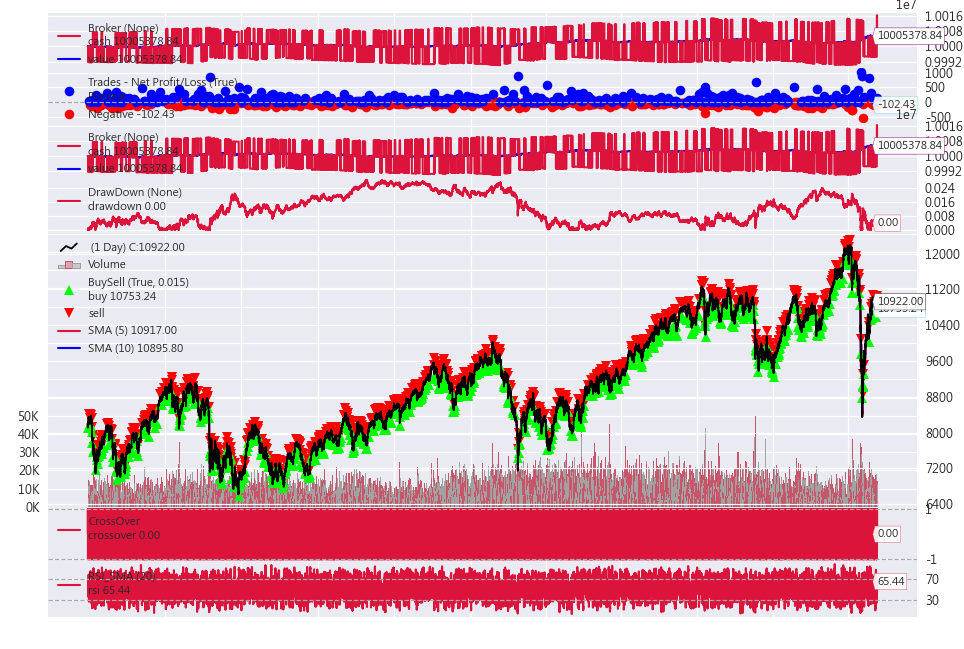

[[<Figure size 432x288 with 8 Axes>]]

In [12]:
cerebro.plot()

# 未平倉每單位部位每日價值變動表

In [13]:
position_value_df=pd.DataFrame(dict(strat.analyzers.PositionsValue.get_analysis()),index=[0]).T
position_value_df.columns=['position value']
position_value_df.tail()

,position value
2020-05-25,10817.0
2020-05-26,10984.0
2020-05-27,10972.0
2020-05-28,10907.0
2020-05-29,0.0


# 未平倉每日報酬率(%)表

In [14]:
daily_return_df=pd.DataFrame(dict(strat.analyzers.TimeReturn.get_analysis()),index=[0]).T
daily_return_df.columns=['daily_return(%)']
daily_return_df['daily_return(%)']=daily_return_df['daily_return(%)']*100*mult
daily_return_df.tail()

,daily_return(%)
2020-05-25,0.139496
2020-05-26,0.333819
2020-05-27,-0.023987
2020-05-28,-0.129928
2020-05-29,-0.239174


# 交易明細表

In [15]:
trade_detail_df=pd.DataFrame(data=[e[0] for e in strat.analyzers.Transactions.get_analysis().values()],
                             columns=['amount','price','sid','symbol','value'],
                             index=strat.analyzers.Transactions.get_analysis().keys())
trade_detail_df.index.name='time'
trade_detail_df.head()

,amount,price,sid,symbol,value
time,,,,,
2010-01-05 09:15:00,1,8242.0,0,,-8242.0
2010-01-08 08:45:00,-1,8287.0,0,,8287.0
2010-01-08 11:00:00,1,8278.0,0,,-8278.0
2010-01-12 11:15:00,-1,8266.0,0,,8266.0
2010-01-12 12:15:00,1,8305.0,0,,-8305.0


# 讀入結果資料

In [16]:
pnl_df=pd.read_csv('15分K_損益明細結果.csv')
pnl_df['時間']=pd.to_datetime(pnl_df['時間'])
pnl_df['年']=pnl_df['時間'].dt.to_period('Y')
pnl_df['年月']=pnl_df['時間'].dt.to_period('M')

trade_df=pd.read_csv('15分K_交易明細結果.csv')
trade_df['時間']=pd.to_datetime(trade_df['時間'])
trade_df['年']=trade_df['時間'].dt.to_period('Y')
trade_df['年月']=trade_df['時間'].dt.to_period('M')

In [17]:
pnl_df.head()

,時間,毛損益,淨損益,累積淨損益,交易成本,滑價,交易稅,平倉權益數,平倉交易K棒數,DD,MDD,年,年月
0,2010-01-08 08:45:00,9000.0,8533.884,8533.884,466.116,400,66.116,1.000853e+07,61,17799.811615,19599.792565,2010,2010-01
1,2010-01-12 11:15:00,-2400.0,-2866.176,5667.708,466.176,400,66.176,1.000567e+07,43,10799.879577,19599.792565,2010,2010-01
2,2010-01-13 12:15:00,-21000.0,-21466.020,-15798.312,466.020,400,66.020,9.984202e+06,21,32665.919762,35665.886311,2010,2010-01
3,2010-01-19 11:45:00,2400.0,1933.968,-13864.344,466.032,400,66.032,9.986136e+06,74,33531.702109,38131.650817,2010,2010-01
4,2010-01-21 09:00:00,-16400.0,-16865.816,-30730.160,465.816,400,65.816,9.969270e+06,22,45197.684029,47597.657268,2010,2010-01


In [18]:
trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
0,2010-01-05 09:15:00,Buy,1,8242.0,8242.0,232.968,200,32.968,-1648632.968,8.351367e+06,2010,2010-01
1,2010-01-08 08:45:00,Sell,-1,8287.0,8242.0,233.148,200,33.148,1657166.852,1.000853e+07,2010,2010-01
2,2010-01-08 11:00:00,Buy,1,8278.0,8278.0,233.112,200,33.112,-1655833.112,8.352701e+06,2010,2010-01
3,2010-01-12 11:15:00,Sell,-1,8266.0,8278.0,233.064,200,33.064,1652966.936,1.000567e+07,2010,2010-01
4,2010-01-12 12:15:00,Buy,1,8305.0,8305.0,233.220,200,33.220,-1661233.220,8.344434e+06,2010,2010-01


# 多空單交易明細結果

In [19]:
long_trade_query='操作 == "Buy" or 操作 == "Sell"'
long_trade_df=trade_df.query(long_trade_query)
long_trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
0,2010-01-05 09:15:00,Buy,1,8242.0,8242.0,232.968,200,32.968,-1648632.968,8.351367e+06,2010,2010-01
1,2010-01-08 08:45:00,Sell,-1,8287.0,8242.0,233.148,200,33.148,1657166.852,1.000853e+07,2010,2010-01
2,2010-01-08 11:00:00,Buy,1,8278.0,8278.0,233.112,200,33.112,-1655833.112,8.352701e+06,2010,2010-01
3,2010-01-12 11:15:00,Sell,-1,8266.0,8278.0,233.064,200,33.064,1652966.936,1.000567e+07,2010,2010-01
4,2010-01-12 12:15:00,Buy,1,8305.0,8305.0,233.220,200,33.220,-1661233.220,8.344434e+06,2010,2010-01


In [20]:
short_trade_query='操作 == "Sellshort" or 操作 == "Buytocover"'
short_trade_df=trade_df.query(short_trade_query)
short_trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
14,2010-01-26 10:30:00,Sellshort,-1,7777.0,-7777.0,231.108,200,31.108,1555168.892,1.148191e+07,2010,2010-01
15,2010-01-28 12:15:00,Buytocover,1,7696.0,-7777.0,230.784,200,30.784,-1539430.784,9.942481e+06,2010,2010-01
16,2010-01-29 09:00:00,Sellshort,-1,7541.0,-7541.0,230.164,200,30.164,1507969.836,1.145045e+07,2010,2010-01
17,2010-02-09 10:00:00,Buytocover,1,7294.0,-7541.0,229.176,200,29.176,-1459029.176,9.991421e+06,2010,2010-02
18,2010-02-10 11:45:00,Sellshort,-1,7410.0,-7410.0,229.640,200,29.640,1481770.360,1.147319e+07,2010,2010-02


# 平倉每日損益表

In [21]:
date_idx=pd.date_range(d1,d2,freq='B')
return_series=pnl_df.set_index('時間').groupby(pd.Grouper(freq='D'))['淨損益'].sum()
return_series=return_series.reindex(date_idx,fill_value=0)
cum_return_series=return_series.cumsum()
cummax_return_series=cum_return_series.cummax()
os_equity_series=startcash+cum_return_series
MDD_series=cummax_return_series-cum_return_series
MDD_ratio_series=MDD_series/os_equity_series*100

return_df=pd.DataFrame({'淨損益':return_series,
                        '累積淨損益':cum_return_series,
                        '累積最大淨損益':cummax_return_series,
                        '平倉權益數':os_equity_series,
                        '最大策略虧損':MDD_series,
                        '最大策略虧損比率(%)':MDD_ratio_series})
return_df.tail()

,淨損益,累積淨損益,累積最大淨損益,平倉權益數,最大策略虧損,最大策略虧損比率(%)
2020-05-25,0.0,680141.448,694714.752,1.068014e+07,14573.304,0.136452
2020-05-26,0.0,680141.448,694714.752,1.068014e+07,14573.304,0.136452
2020-05-27,0.0,680141.448,694714.752,1.068014e+07,14573.304,0.136452
2020-05-28,0.0,680141.448,694714.752,1.068014e+07,14573.304,0.136452
2020-05-29,7226.5,687367.948,694714.752,1.068737e+07,7346.804,0.068743


# 平倉累積淨損益、累積最大淨損益圖

<IPython.core.display.Javascript object>


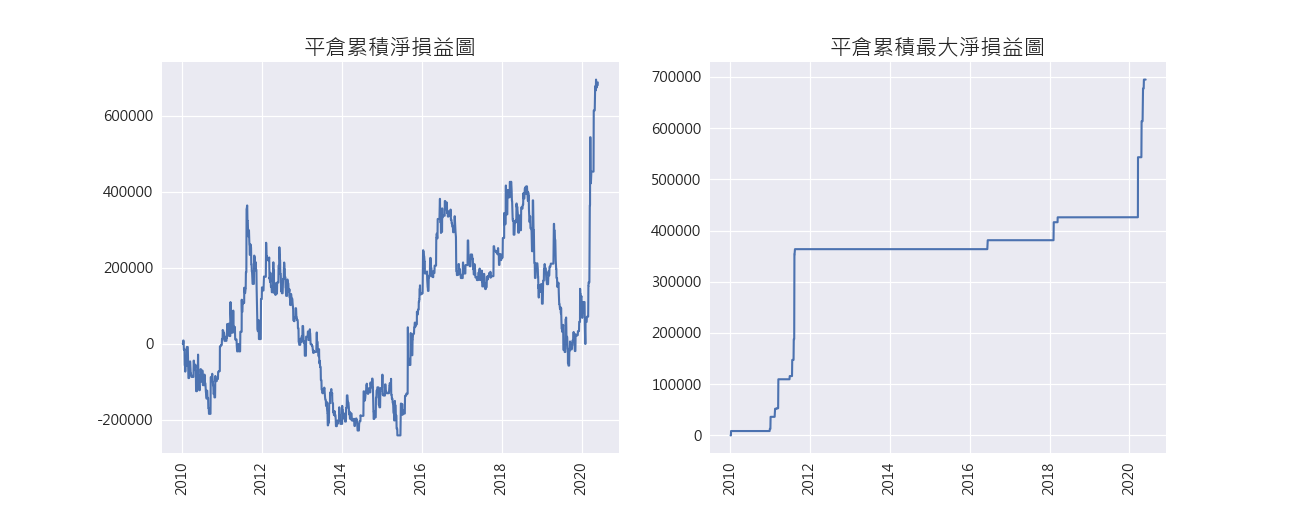

In [22]:
fig,axes=plt.subplots(1,2,figsize=(15,6))
axes[0].plot(cum_return_series)
axes[0].set_title('平倉累積淨損益圖',fontsize=18)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].tick_params(axis='x',labelsize=12,rotation=90)
axes[0].tick_params(axis='y',labelsize=12)

axes[1].plot(cummax_return_series)
axes[1].set_title('平倉累積最大淨損益圖',fontsize=18)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[1].tick_params(axis='x',labelsize=12,rotation=90)
axes[1].tick_params(axis='y',labelsize=12)

# 平倉權益曲線和績效拉回圖

<IPython.core.display.Javascript object>


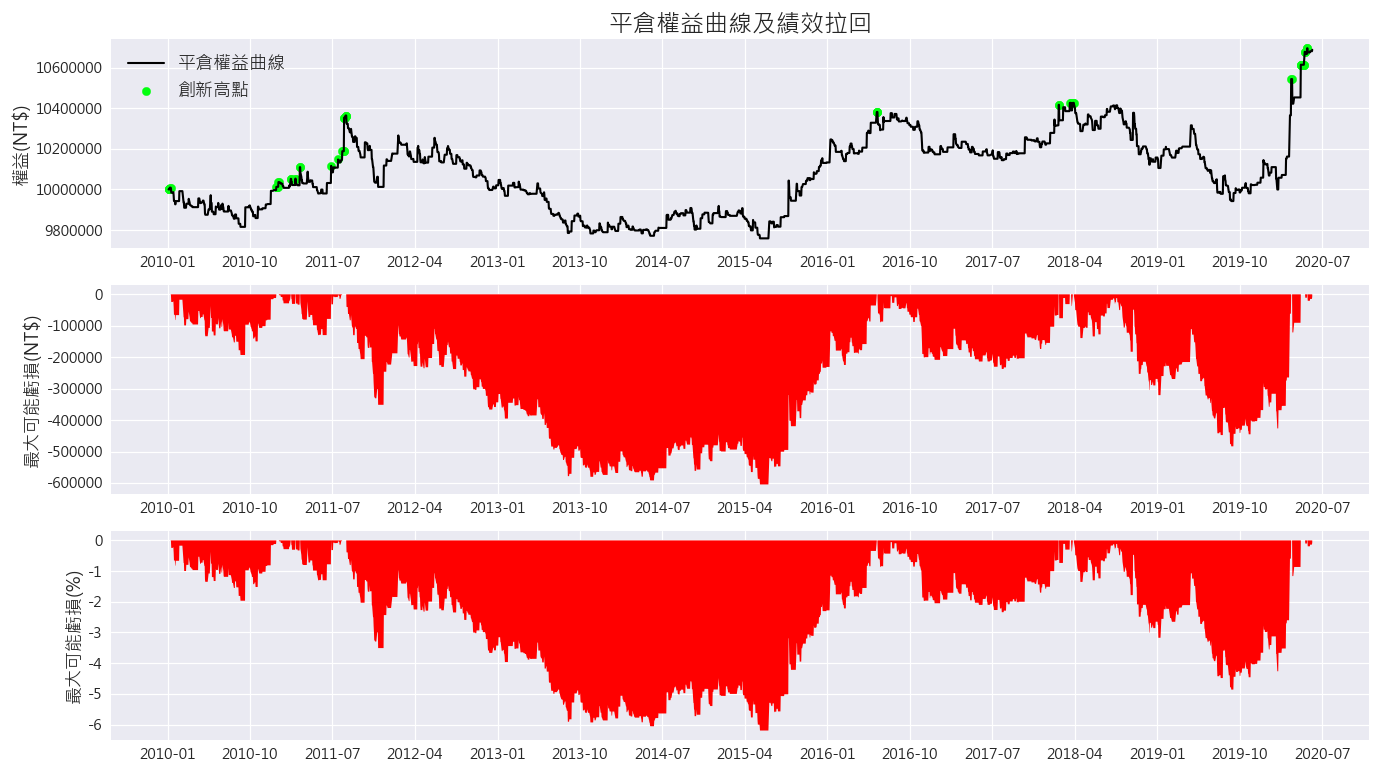

In [23]:
high_index=cum_return_series[cummax_return_series==cum_return_series].index

fig,axes=plt.subplots(3,figsize=(16,9),sharex=True)
axes[0].plot(os_equity_series,label='平倉權益曲線',color='k')
axes[0].scatter(high_index,os_equity_series.loc[high_index],color='#02ff0f',label='創新高點')
axes[0].set_title('平倉權益曲線及績效拉回',fontsize=20)
axes[0].set_ylabel('權益(NT$)',fontsize=15)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=9))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].legend(fontsize=15,loc='upper left')
axes[0].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[0].tick_params(axis='y',labelsize=12)

axes[1].fill_between(MDD_series.index,-MDD_series,0,facecolor='r')
axes[1].set_ylabel('最大可能虧損(NT$)',fontsize=15)
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=9))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[1].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[1].tick_params(axis='y',labelsize=12)

axes[2].fill_between(MDD_ratio_series.index,-MDD_ratio_series,0,facecolor='r')
axes[2].set_ylabel('最大可能虧損(%)',fontsize=15)
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=9))
axes[2].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[2].tick_params(axis='y',labelsize=12)

fig.tight_layout()

# 年週期分析表

In [24]:
yearly_pnl=pnl_df.groupby(['年'])['淨損益'].sum()
yearly_pnl_rate=yearly_pnl/startcash*100
# 毛利:獲利交易淨利和
yearly_gross_profit=pnl_df.groupby(['年'])['淨損益'].apply(sum_positive_series)
# 毛損:虧損交易淨損和
yearly_gross_loss=yearly_pnl-yearly_gross_profit

yearly_trade_num=pnl_df.groupby(['年'])['淨損益'].count()*2
yearly_win_trade_num=pnl_df.groupby(['年'])['淨損益'].apply(count_positive_series)*2
yearly_win_rate=(yearly_win_trade_num/yearly_trade_num)*100

yearly_trade_df=pd.DataFrame({'獲利金額':yearly_pnl.apply(lambda x:'{:.2f}'.format(x)),
                              '獲利 (%)':yearly_pnl_rate.apply(lambda x:'{:.2f}%'.format(x)),
                              '毛利':yearly_gross_profit.apply(lambda x:'{:.2f}'.format(x)),
                              '毛損':yearly_gross_loss.apply(lambda x:'{:.2f}'.format(x)),
                              '交易次數':yearly_trade_num,
                              '勝率 (%)':yearly_win_rate.apply(lambda x:'{:.2f}%'.format(x))})
yearly_trade_df

,獲利金額,獲利 (%),毛利,毛損,交易次數,勝率 (%)
年,,,,,,
2010,12743.66,0.13%,726591.78,-713848.13,168,41.67%
2011,135482.74,1.35%,1038666.93,-903184.19,194,34.02%
2012,-128051.96,-1.28%,647155.81,-775207.77,210,29.52%
2013,-230844.34,-2.31%,407809.18,-638653.52,200,31.00%
2014,94134.22,0.94%,544023.58,-449889.35,176,37.50%
2015,249254.10,2.49%,808150.39,-558896.29,182,35.16%
2016,40104.86,0.40%,669050.40,-628945.54,174,32.18%
2017,53831.06,0.54%,486511.33,-432680.26,172,32.56%
2018,-69734.66,-0.70%,940314.54,-1010049.20,216,36.11%


# 每年獲利和虧損圖

<IPython.core.display.Javascript object>


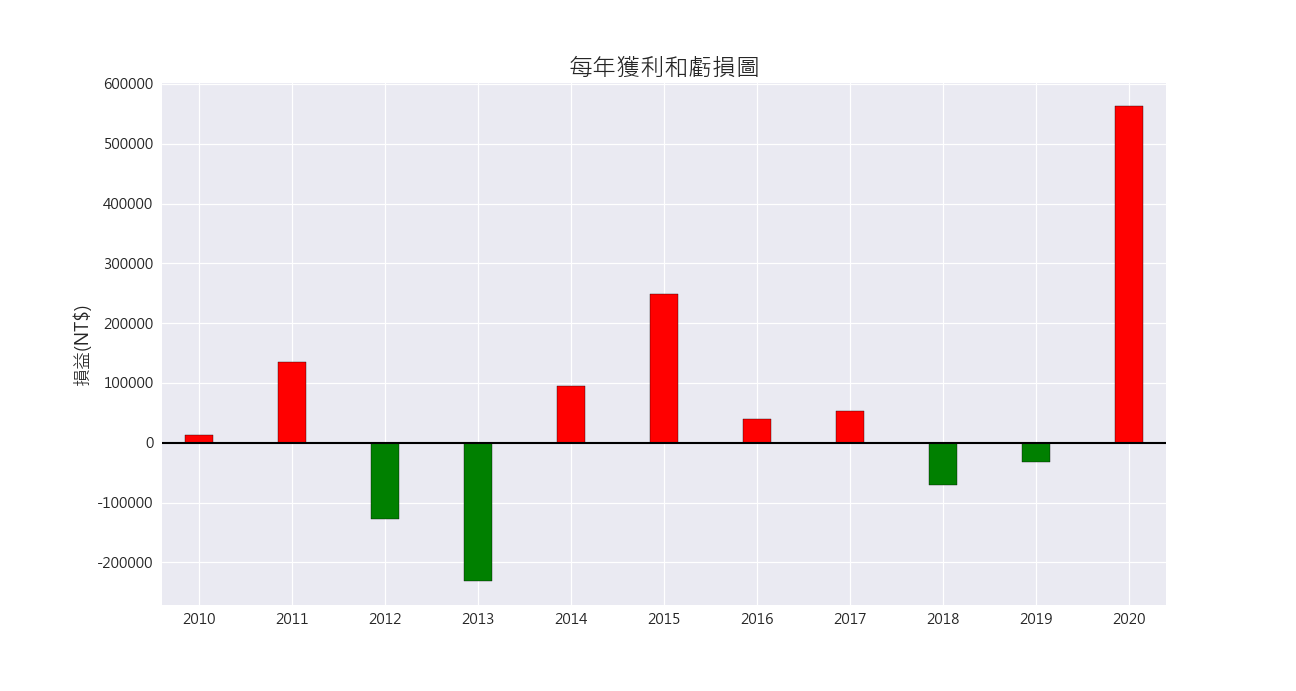

In [25]:
positive=yearly_pnl>0

fig,ax=plt.subplots(1,figsize=(15,8))
yearly_pnl.plot(kind='bar',color=positive.map({True:'r',False:'g'}),edgecolor='k',width=0.3,ax=ax)
ax.axhline(y=0,color='k',linestyle='-')
ax.set_title('每年獲利和虧損圖',fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel('損益(NT$)',fontsize=15)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12,rotation=0)

# 月週期分析表

In [26]:
month_idx=pd.date_range(d1,d2,freq='MS').to_period('M')
monthly_pnl=pnl_df.groupby(['年月'])['淨損益'].sum()
monthly_pnl=monthly_pnl.reindex(month_idx,fill_value=0)
monthly_pnl_rate=monthly_pnl/startcash*100

monthly_gross_profit=pnl_df.groupby(['年月'])['淨損益'].apply(sum_positive_series)
monthly_gross_profit=monthly_gross_profit.reindex(month_idx,fill_value=0)
monthly_gross_loss=monthly_pnl-monthly_gross_profit

monthly_trade_num=pnl_df.groupby(['年月'])['淨損益'].count()*2
monthly_trade_num=monthly_trade_num.reindex(month_idx,fill_value=0)
monthly_win_trade_num=pnl_df.groupby(['年月'])['淨損益'].apply(count_positive_series)*2
monthly_win_trade_num=monthly_win_trade_num.reindex(month_idx,fill_value=0)
monthly_win_rate=(monthly_win_trade_num/monthly_trade_num)*100

monthly_trade_df=pd.DataFrame({'獲利金額':monthly_pnl.apply(lambda x:'{:.2f}'.format(x)),
                               '獲利 (%)':monthly_pnl_rate.apply(lambda x:'{:.2f}%'.format(x) if not np.isnan(x) else x),
                               '毛利':monthly_gross_profit.apply(lambda x:'{:.2f}'.format(x)),
                               '毛損':monthly_gross_loss.apply(lambda x:'{:.2f}'.format(x)),
                               '交易次數':monthly_trade_num,
                               '勝率 (%)':monthly_win_rate.apply(lambda x:'{:.2f}%'.format(x) if not np.isnan(x) else x)})
monthly_trade_df.tail()

,獲利金額,獲利 (%),毛利,毛損,交易次數,勝率 (%)
2020-01,-71273.21,-0.71%,45007.85,-116281.06,14,28.57%
2020-02,17430.82,0.17%,71722.22,-54291.40,8,75.00%
2020-03,381460.68,3.81%,502693.65,-121232.96,18,66.67%
2020-04,160839.32,1.61%,163120.85,-2281.53,4,50.00%
2020-05,73798.58,0.74%,125657.29,-51858.71,14,57.14%


# 每月獲利和虧損圖

<IPython.core.display.Javascript object>


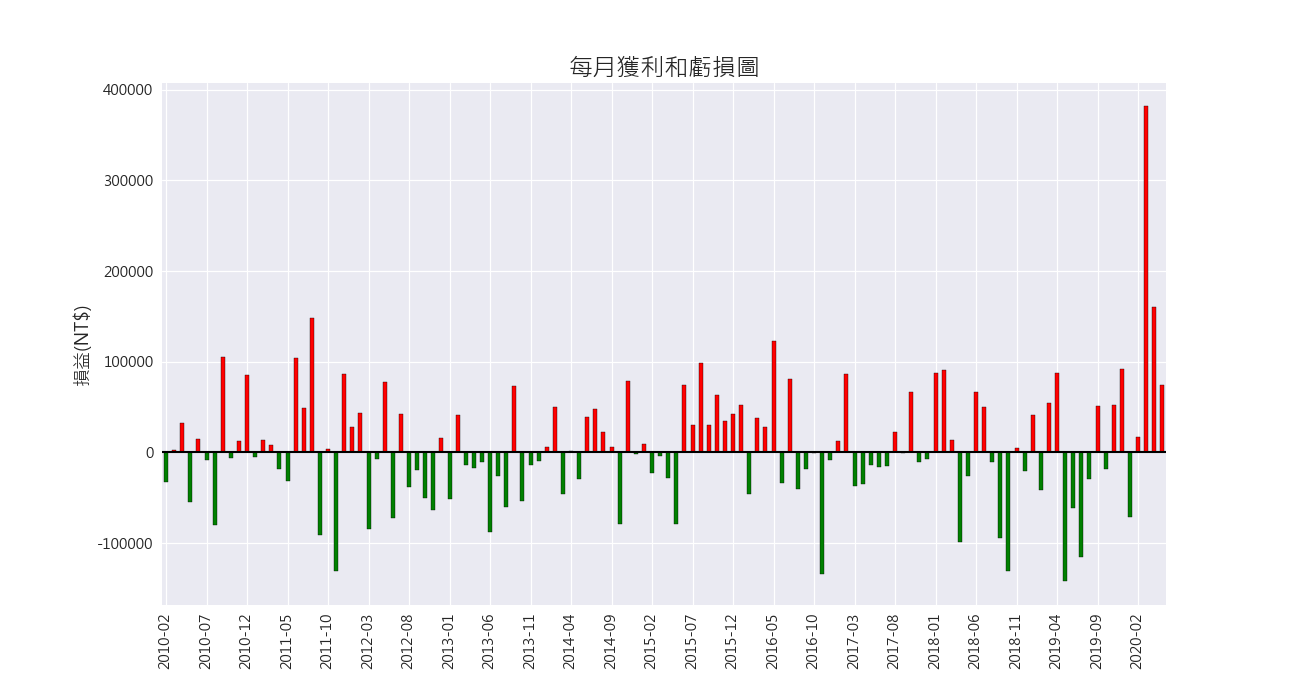

In [27]:
positive=monthly_pnl>0

fig,ax=plt.subplots(1,figsize=(15,8))
monthly_pnl.plot(kind='bar',color=positive.map({True:'r',False:'g'}),edgecolor='k',ax=ax)
ax.axhline(y=0,color='k',linestyle='-')
ax.set_title('每月獲利和虧損圖',fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel('損益(NT$)',fontsize=15)
ax.set_xticks(range(0,len(monthly_pnl.index),5))
ax.set_xticklabels(monthly_pnl.index[::5],fontsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12,rotation=90)

# 策略績效總結果表

In [28]:
total_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['won']['pnl']['total']*mult,TradeAnalyzer_information['won']['total']*2)
total_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['lost']['pnl']['total']*mult,TradeAnalyzer_information['total']['total']*2)
long_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['long']['pnl']['won']['total']*mult,TradeAnalyzer_information['long']['won']*2)
long_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['long']['pnl']['lost']['total']*mult,TradeAnalyzer_information['long']['total']*2)
short_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['short']['pnl']['won']['total']*mult,TradeAnalyzer_information['short']['won']*2)
short_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['short']['pnl']['lost']['total']*mult,TradeAnalyzer_information['short']['total']*2)


total_performance=['{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['total']*mult),
                   '{:.2f}'.format(TradeAnalyzer_information['won']['pnl']['total']*mult),
                   '{:.2f}'.format(TradeAnalyzer_information['lost']['pnl']['total']*mult),
                   '{:.2f}'.format(total_adjust_gross_profit+total_adjust_gross_loss),
                   '{:.2f}'.format(total_adjust_gross_profit),
                   '{:.2f}'.format(total_adjust_gross_loss),
                   ratio(TradeAnalyzer_information['won']['pnl']['total'],-TradeAnalyzer_information['lost']['pnl']['total']),
                   ratio(total_adjust_gross_profit,-total_adjust_gross_loss),
                   '{:.2f}'.format(trade_df['交易成本'].sum()),
                   '{:.2f}'.format(trade_df['滑價'].sum()),
                   '{:.2f}'.format(trade_df['交易稅'].sum())]

long_performance=['{:.2f}'.format(TradeAnalyzer_information['long']['pnl']['total']*mult),
                  '{:.2f}'.format(TradeAnalyzer_information['long']['pnl']['won']['total']*mult),
                  '{:.2f}'.format(TradeAnalyzer_information['long']['pnl']['lost']['total']*mult),
                  '{:.2f}'.format(long_adjust_gross_profit+long_adjust_gross_loss),
                  '{:.2f}'.format(long_adjust_gross_profit),
                  '{:.2f}'.format(long_adjust_gross_loss),
                  ratio(TradeAnalyzer_information['long']['pnl']['won']['total'],-TradeAnalyzer_information['long']['pnl']['lost']['total']),
                  ratio(long_adjust_gross_profit,-long_adjust_gross_loss),
                  '{:.2f}'.format(long_trade_df['交易成本'].sum()),
                  '{:.2f}'.format(long_trade_df['滑價'].sum()),
                  '{:.2f}'.format(long_trade_df['交易稅'].sum())]

short_performance=['{:.2f}'.format(TradeAnalyzer_information['short']['pnl']['total']*mult),
                   '{:.2f}'.format(TradeAnalyzer_information['short']['pnl']['won']['total']*mult),
                   '{:.2f}'.format(TradeAnalyzer_information['short']['pnl']['lost']['total']*mult),
                   '{:.2f}'.format(short_adjust_gross_profit+short_adjust_gross_loss),
                   '{:.2f}'.format(short_adjust_gross_profit),
                   '{:.2f}'.format(short_adjust_gross_loss),
                   ratio(TradeAnalyzer_information['short']['pnl']['won']['total'],-TradeAnalyzer_information['short']['pnl']['lost']['total']),
                   ratio(short_adjust_gross_profit,-short_adjust_gross_loss),
                   '{:.2f}'.format(short_trade_df['交易成本'].sum()),
                   '{:.2f}'.format(short_trade_df['滑價'].sum()),
                   '{:.2f}'.format(short_trade_df['交易稅'].sum())]

total_performance_df=pd.DataFrame({'所有交易':total_performance,
                                   '多單':long_performance,
                                   '空單':short_performance})

total_performance_df.index=['淨利','毛利','毛損','調整後淨利','調整後毛利','調整後毛損','獲利因子','調整後獲利因子',
                            '交易成本支付','滑價支付','交易稅支付']
total_performance_df

,所有交易,多單,空單
淨利,687367.95,558679.28,128688.67
毛利,7881161.70,4506086.61,3375075.09
毛損,-7193793.75,-3947407.34,-3246386.42
調整後淨利,-9133690095.21,-2617537558.86,-2050852207.28
調整後毛利,5153674402.76,1791417045.39,829639310.21
調整後毛損,-14287364497.97,-4408954604.25,-2880491517.49
獲利因子,1.1,1.14,1.04
調整後獲利因子,0.36,0.41,0.29
交易成本支付,458432.05,256320.72,202111.33
滑價支付,388400.00,216800.00,171600.00


# 總交易分析表

In [29]:
total_trade=[int(TradeAnalyzer_information['total']['total']*2),
             int(TradeAnalyzer_information['won']['total']*2),
             int(TradeAnalyzer_information['lost']['total']*2),
             percentage(TradeAnalyzer_information['won']['total'],TradeAnalyzer_information['total']['total']),
             round(TradeAnalyzer_information['pnl']['net']['average']*mult,2),
             round(TradeAnalyzer_information['won']['pnl']['average']*mult,2),
             round(TradeAnalyzer_information['lost']['pnl']['average']*mult,2),
             ratio(TradeAnalyzer_information['won']['pnl']['average'],-TradeAnalyzer_information['lost']['pnl']['average']),
             round(TradeAnalyzer_information['won']['pnl']['max']*mult,2),
             round(TradeAnalyzer_information['lost']['pnl']['max']*mult,2),
             round(TradeAnalyzer_information['len']['average'],1),
             round(TradeAnalyzer_information['len']['won']['average'],1),
             round(TradeAnalyzer_information['len']['lost']['average'],1)]

long_trade=[int(TradeAnalyzer_information['long']['total']*2),
            int(TradeAnalyzer_information['long']['won']*2),
            int(TradeAnalyzer_information['long']['lost']*2),
            percentage(TradeAnalyzer_information['long']['won'],TradeAnalyzer_information['long']['total']),
            round(TradeAnalyzer_information['long']['pnl']['average']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['won']['average']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['lost']['average']*mult,2),
            ratio(TradeAnalyzer_information['long']['pnl']['won']['average'],-TradeAnalyzer_information['long']['pnl']['lost']['average']),
            round(TradeAnalyzer_information['long']['pnl']['won']['max']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['lost']['max']*mult,2),
            round(TradeAnalyzer_information['len']['long']['average'],1),
            round(TradeAnalyzer_information['len']['long']['won']['average'],1),
            round(TradeAnalyzer_information['len']['long']['lost']['average'],1)]

short_trade=[int(TradeAnalyzer_information['short']['total']*2),
             int(TradeAnalyzer_information['short']['won']*2),
             int(TradeAnalyzer_information['short']['lost']*2),
             percentage(TradeAnalyzer_information['short']['won'],TradeAnalyzer_information['short']['total']),
             round(TradeAnalyzer_information['short']['pnl']['average']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['won']['average']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['lost']['average']*mult,2),
             ratio(TradeAnalyzer_information['short']['pnl']['won']['average'],-TradeAnalyzer_information['short']['pnl']['lost']['average']),
             round(TradeAnalyzer_information['short']['pnl']['won']['max']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['lost']['max']*mult,2),
             round(TradeAnalyzer_information['len']['short']['average'],1),
             round(TradeAnalyzer_information['len']['short']['won']['average'],1),
             round(TradeAnalyzer_information['len']['short']['lost']['average'],1)]

total_trade_df=pd.DataFrame({'所有交易':total_trade,
                             '多單':long_trade,
                             '空單':short_trade})

total_trade_df.index=['交易總次數','獲利交易次數','虧損交易次數','勝率','平均交易(獲利 虧損)','平均獲利交易',
                      '平均虧損交易','平均獲利/平均虧損 比率','最大的交易獲利','最大的交易虧損','平倉交易的平均K棒數',
                      '獲利平倉交易的平均K棒數','虧損平倉交易的平均K棒數']
total_trade_df

,所有交易,多單,空單
交易總次數,1942,1084,858
獲利交易次數,680,418,262
虧損交易次數,1262,666,596
勝率,35.02%,38.56%,30.54%
平均交易(獲利 虧損),707.9,1030.77,299.97
平均獲利交易,23179.9,21560.2,25763.9
平均虧損交易,-11400.6,-11854.1,-10893.9
平均獲利/平均虧損 比率,2.03,1.82,2.36
最大的交易獲利,202916,163121,202916
最大的交易虧損,-109072,-75883,-109072


# 策略交易績效概況表

In [30]:
summary_list=['{} ~ {}'.format(d1,d2),
              total_day_num,
              '{:.2f}'.format(startcash),
              '{:.2f}'.format(startcash+TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['total']*mult-TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['average']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['average']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['average']*mult-TradeAnalyzer_information['pnl']['net']['average']*mult),
              '{:.4f}%'.format(TradeAnalyzer_information['pnl']['net']['total']*mult/startcash*100),
              '{:.4f}%'.format(daily_return_df['daily_return(%)'].mean()),
              '{:.4f}%'.format(((1+TradeAnalyzer_information['pnl']['net']['total']*mult/startcash)**(252/total_day_num)-1)*100),
              '{:.2f}'.format(DW_information['moneydown']*mult),
              '{:.4f}%'.format(DW_information['moneydown']*mult/startcash*100),
              DW_information['len'],
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['total']/DW_information['moneydown']),
              TradeAnalyzer_information['total']['total']*2,
              TradeAnalyzer_information['streak']['won']['longest'],
              TradeAnalyzer_information['streak']['lost']['longest']]


title_list=['回測期間','總天數','初始資金','期末資金','總交易毛損利','總交易净損利','交易稅和滑價','總交易平均毛損利','總交易平均淨損利',
            '平均交易稅和滑價','總報酬率(%)','總平均報酬率(%)','總年化報酬率(%)','MDD金額','MDD比率(%)','MDD回復天數','最大策略虧損報酬(風報比)',
            '總交易次數','最長連續獲利次數','最長連續虧損次數']

total_summary_df=pd.DataFrame([summary_list],columns=title_list).T
total_summary_df.columns=['績效概述']
total_summary_df

,績效概述
回測期間,2010-01-04 ~ 2020-05-29
總天數,3798
初始資金,10000000.00
期末資金,10687367.95
總交易毛損利,1145800.00
總交易净損利,687367.95
交易稅和滑價,458432.05
總交易平均毛損利,1180.02
總交易平均淨損利,707.90
平均交易稅和滑價,472.12
